In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision as torchvision
from torchvision import datasets as datasets
import torchvision.transforms as transforms



In [113]:
def gradient_penalty(critic,real,fake,device='cpu'):
  batch_size,C,H,W= real.shape
  epsilon=torch.rand((batch_size,1,1,1)).repeat(1,C,H,W).to(device)
  interpolated_images=real*epsilon+fake*(1-epsilon)

  #calculate critic scores
  mixed=critic(interpolated_images)
  gradient=torch.autograd.grad(
      inputs=interpolated_images,
      outputs=mixed,
      grad_outputs=torch.ones_like(mixed),
      create_graph=True,
      retain_graph=True,
  )[0]

  gradient=gradient.view(gradient.shape[0],-1)
  gradient_norm=gradient.norm(2,dim=1)
  gradient_penalty=torch.mean((gradient_norm-1)**2)
  return gradient_penalty

class Discriminator(nn.Module):
    def __init__(self, channels_img=3, features_d=64):
        super().__init__()
        self.disc = nn.Sequential(
            # Input: 32x32x3
            self._block(channels_img, features_d, 4, 2, 1),  # 16x16
            self._block(features_d, features_d * 2, 4, 2, 1),  # 8x8
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  # 4x4
            nn.Conv2d(features_d * 4, 1, kernel_size=4, stride=1, padding=0),  # 1x1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim=100, channels_img=3, features_g=64):
        super().__init__()
        self.gen = nn.Sequential(
            # Input: Nx100x1x1
            self._block(z_dim, features_g * 8, 4, 1, 0),  # 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 16x16
            nn.ConvTranspose2d(features_g * 2, channels_img, 4, 2, 1),  # 32x32
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def sample(self, z):
        """Generate a batch of images."""
        with torch.no_grad():
            samples = self.forward(z)
        return samples

    def forward(self, x):
        return self.gen(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.2)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

def test():
   N,in_channels,H,W= 8,3,32,32
   z_dim=100
   x=torch.randn(N,in_channels,H,W)
   disc=Discriminator(in_channels,8)
   initialize_weights(disc)
   assert disc(x).shape == (N,1,1,1)
   gen = Generator(z_dim,in_channels,8)
   initialize_weights(gen)
   z=torch.randn(N,z_dim,1,1)
   assert gen(z).shape==(N,in_channels,H,W)
   print("Success")

#test()

In [114]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp
from torch.nn.utils import spectral_norm    
from torch import optim;
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device.type)

# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize([32,32]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')
print("Number of classes: ", len(class_names))

batch_size = 64

num_batches_per_epoch = len(train_loader.dataset) // batch_size

print("Length of train_loader: ", len(train_loader.dataset))

num_of_epochs = 50000 // num_batches_per_epoch

print("Number of batches per epoch: ", num_batches_per_epoch)
print("Number of epochs: ", num_of_epochs)

cuda
Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000
Number of classes:  100
Length of train_loader:  50000
Number of batches per epoch:  781
Number of epochs:  64


In [115]:
# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE=1e-4
Batch_size=64
image_size=32
channels_img=3
z_dim=100
features_disc=28
features_gen=28
critc_iterations=5
lambda_gp=10

gen=Generator(z_dim,channels_img,features_gen).to(device)
critic=Discriminator(channels_img,features_disc).to(device)

print("Parameters of Generator: ", sum(p.numel() for p in gen.parameters() if p.requires_grad))
print("Parameters of Discriminator: ", sum(p.numel() for p in critic.parameters() if p.requires_grad))
print("Total Parameters: ", sum(p.numel() for p in gen.parameters() if p.requires_grad) + sum(p.numel() for p in critic.parameters() if p.requires_grad))

initialize_weights(gen)
initialize_weights(critic)
opt_gen=optim.Adam(gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
opt_critic=optim.Adam(critic.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))

fixed_noise=torch.randn(32,z_dim,1,1).to(device)
step=0
gen.train()
critic.train()

epoch = 0
num_of_epochs = 32

Parameters of Generator:  863635
Parameters of Discriminator:  128969
Total Parameters:  992604


Epochs[1000/50000] Loss D: 2.5488, Loss G: 3.1302


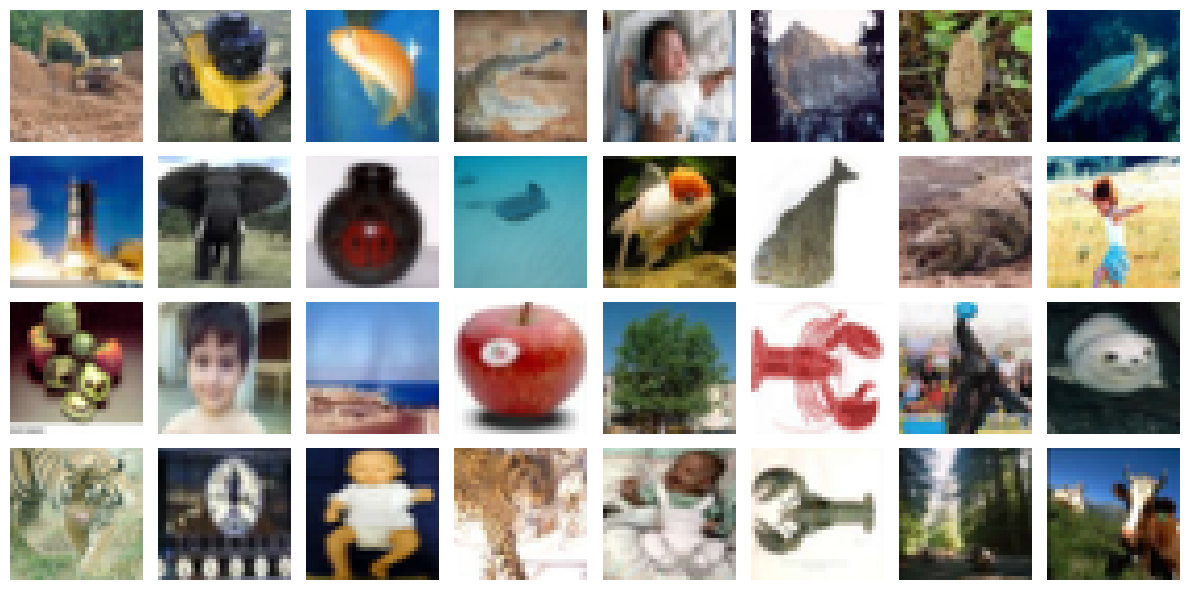

Epochs[2000/50000] Loss D: -1.8851, Loss G: 9.8873


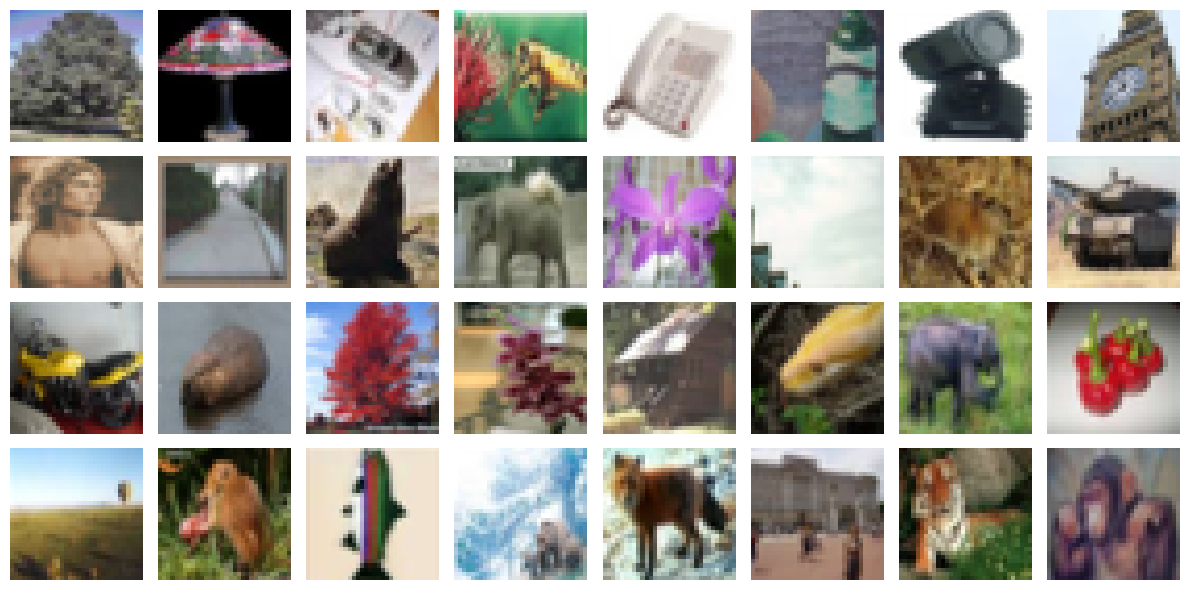

Epochs[3000/50000] Loss D: -3.1993, Loss G: 14.1859


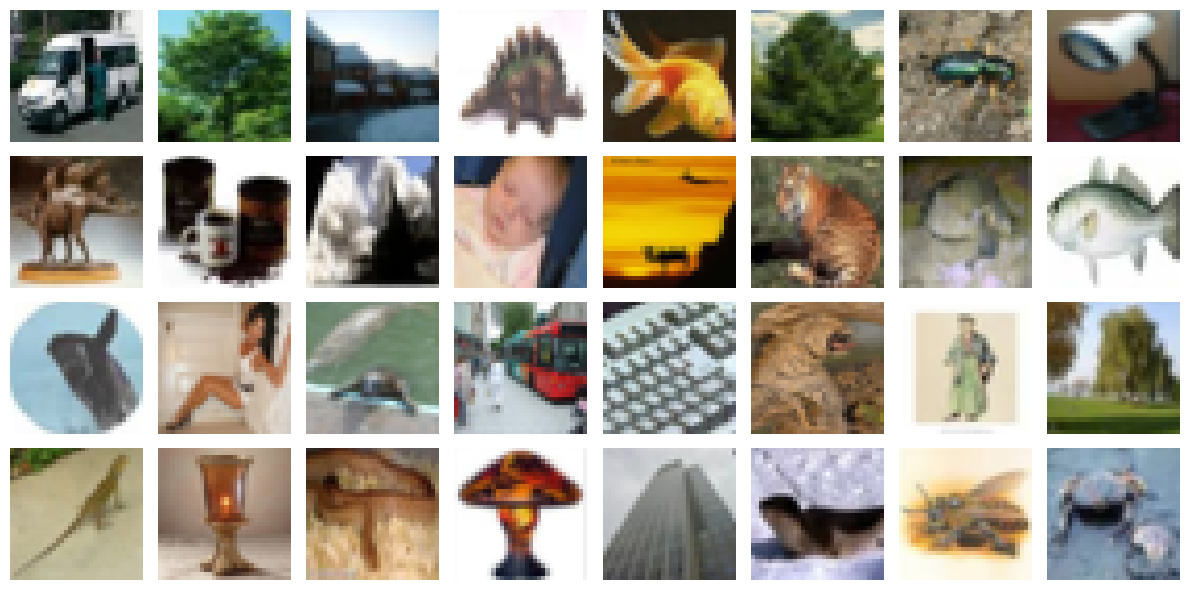

Epochs[4000/50000] Loss D: -3.2085, Loss G: 13.1418


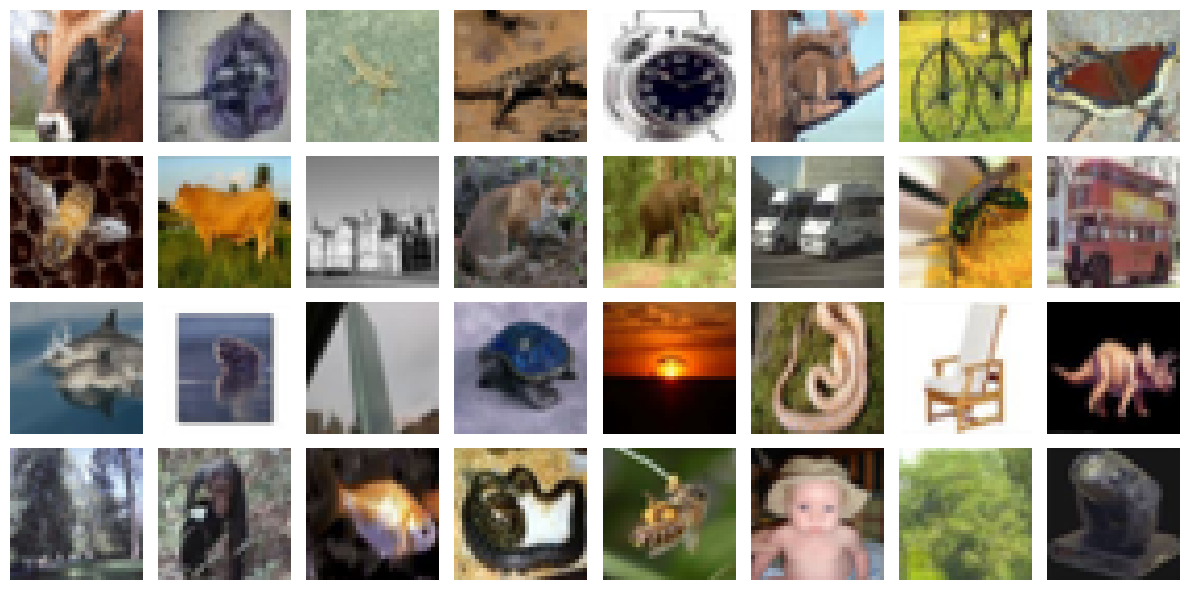

Epochs[5000/50000] Loss D: -2.4205, Loss G: 13.2695


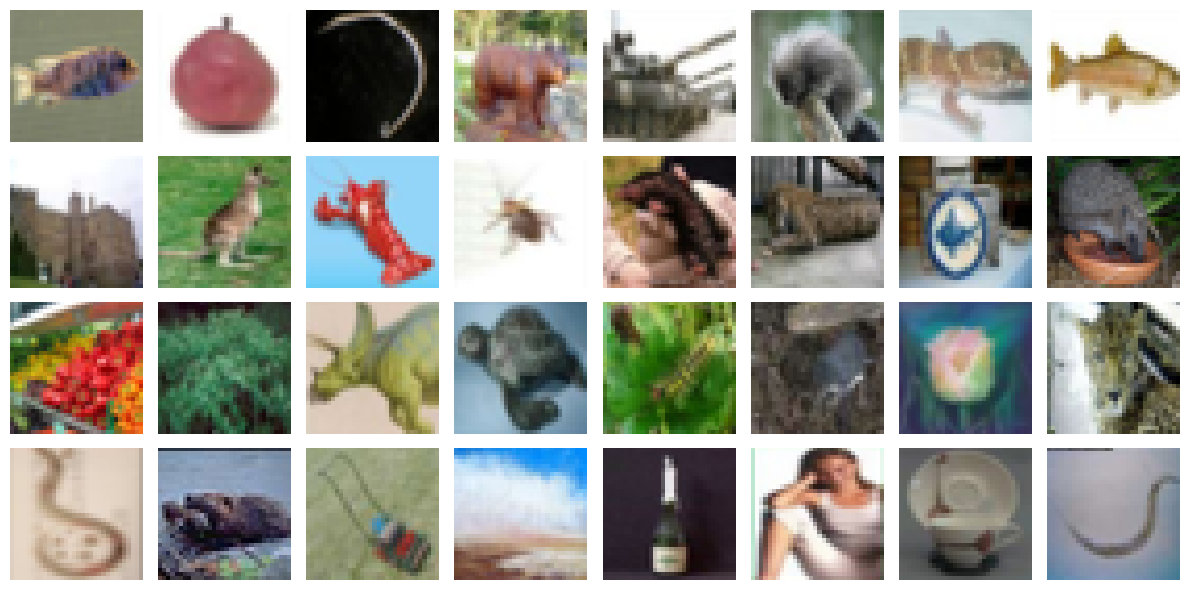

Epochs[6000/50000] Loss D: -2.8252, Loss G: 15.5445


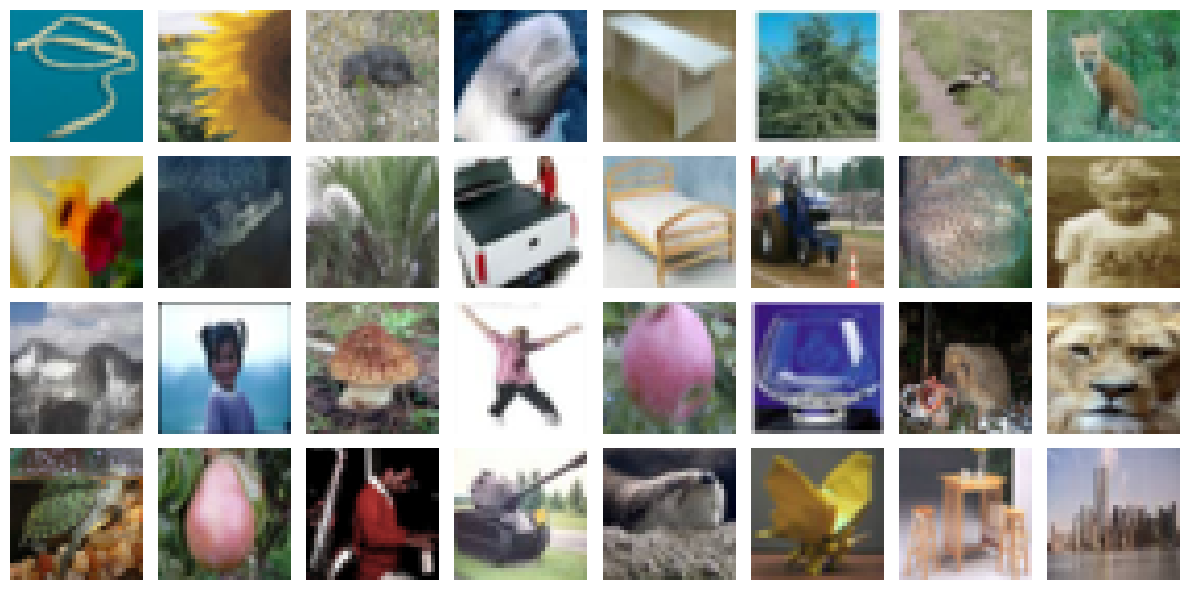

Epochs[7000/50000] Loss D: -2.8188, Loss G: 18.9231


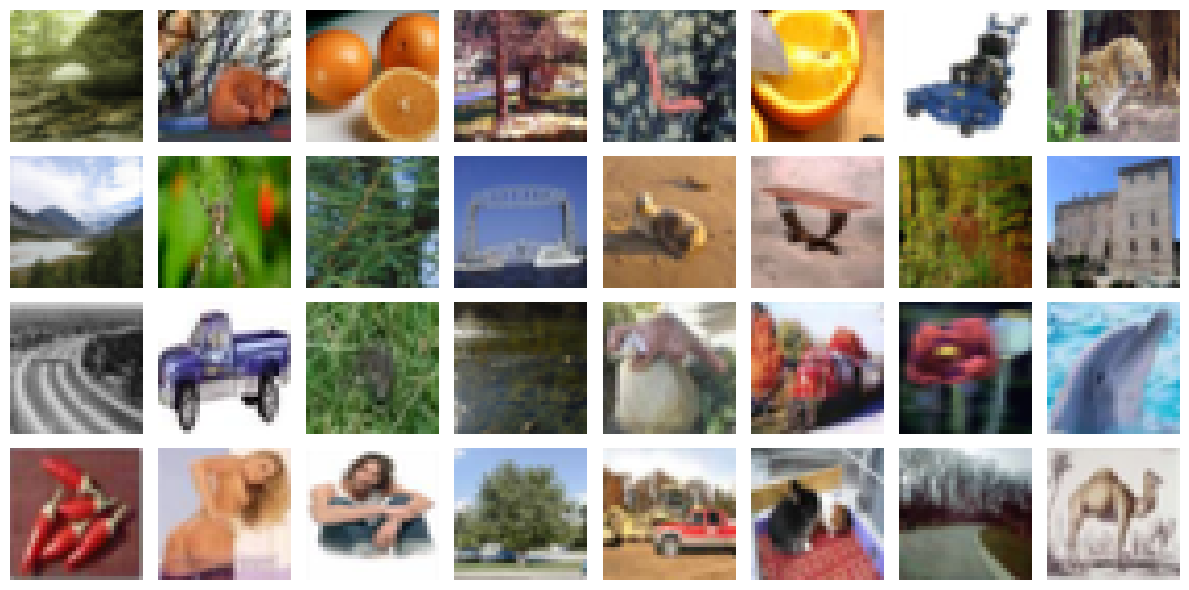

Epochs[8000/50000] Loss D: -2.9602, Loss G: 21.1274


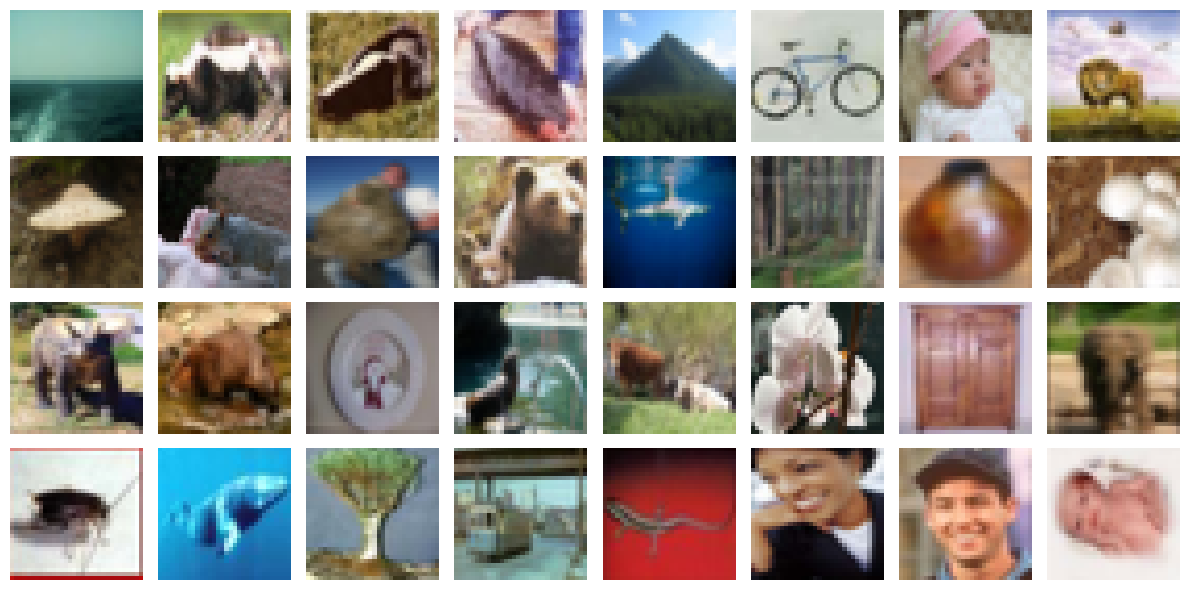

Epochs[9000/50000] Loss D: -3.3558, Loss G: 23.1788


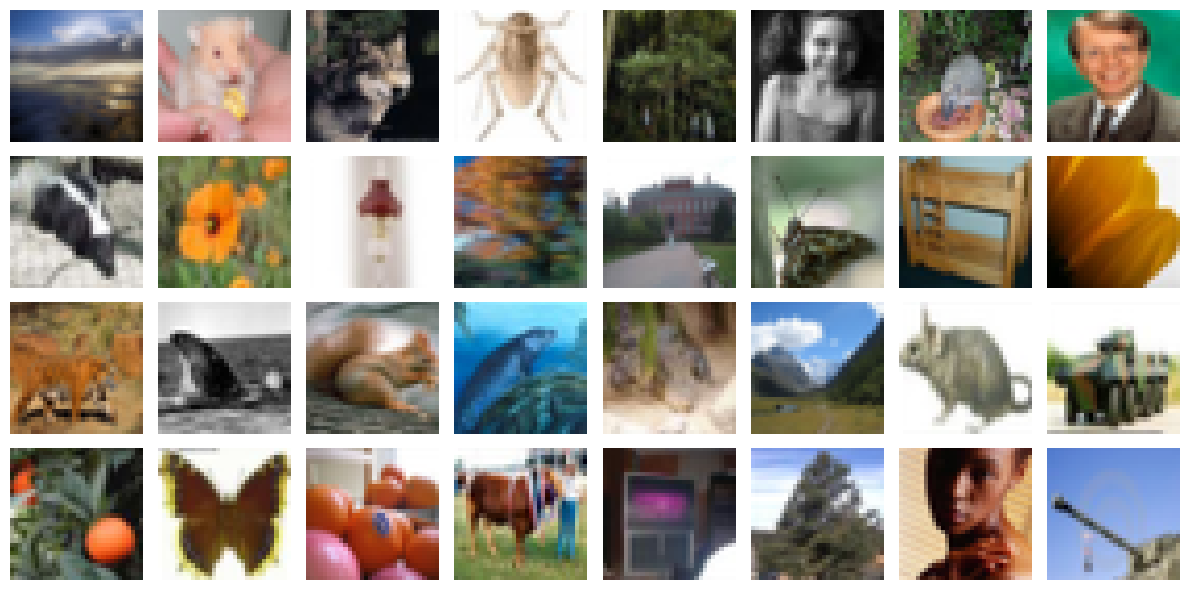

Epochs[10000/50000] Loss D: -2.9566, Loss G: 24.3989


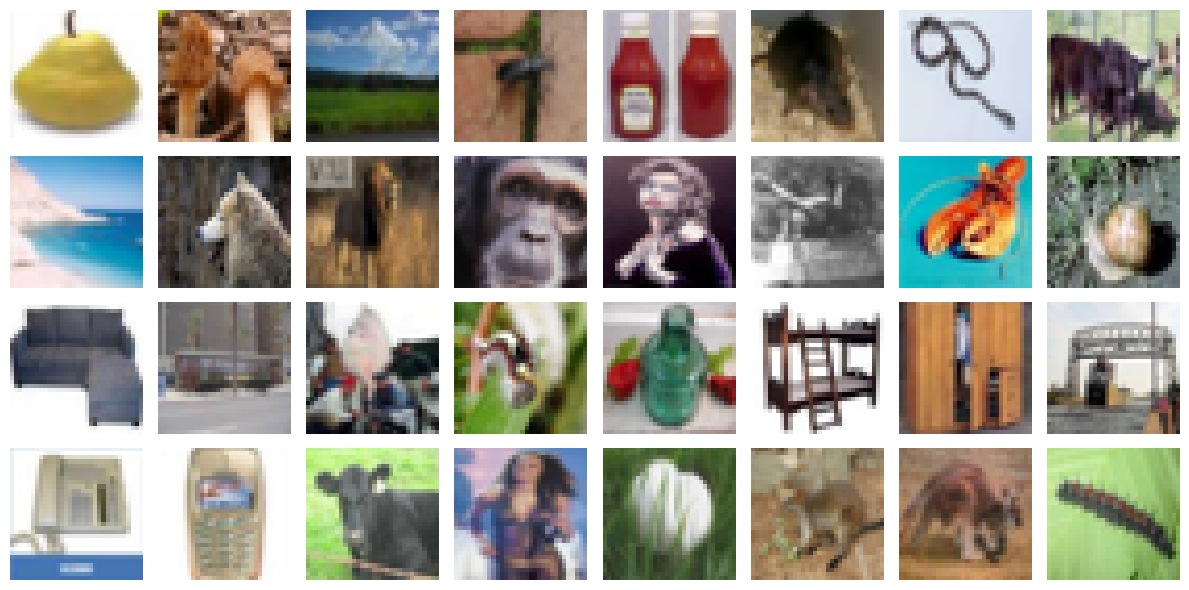

Epochs[11000/50000] Loss D: -2.6793, Loss G: 24.3311


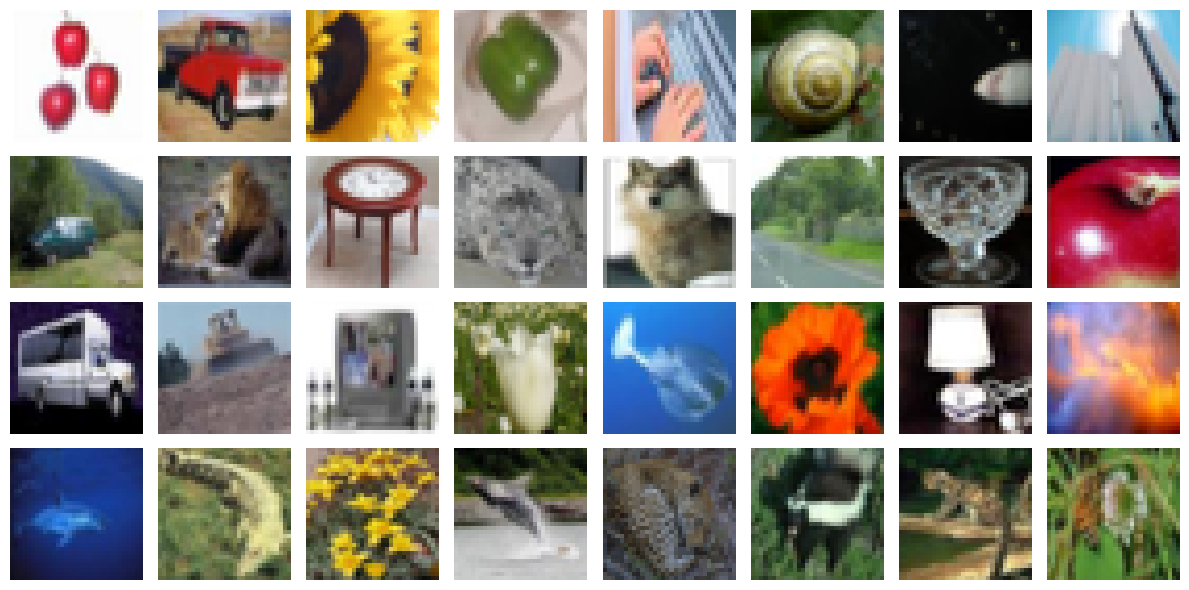

Epochs[12000/50000] Loss D: -2.2842, Loss G: 23.0287


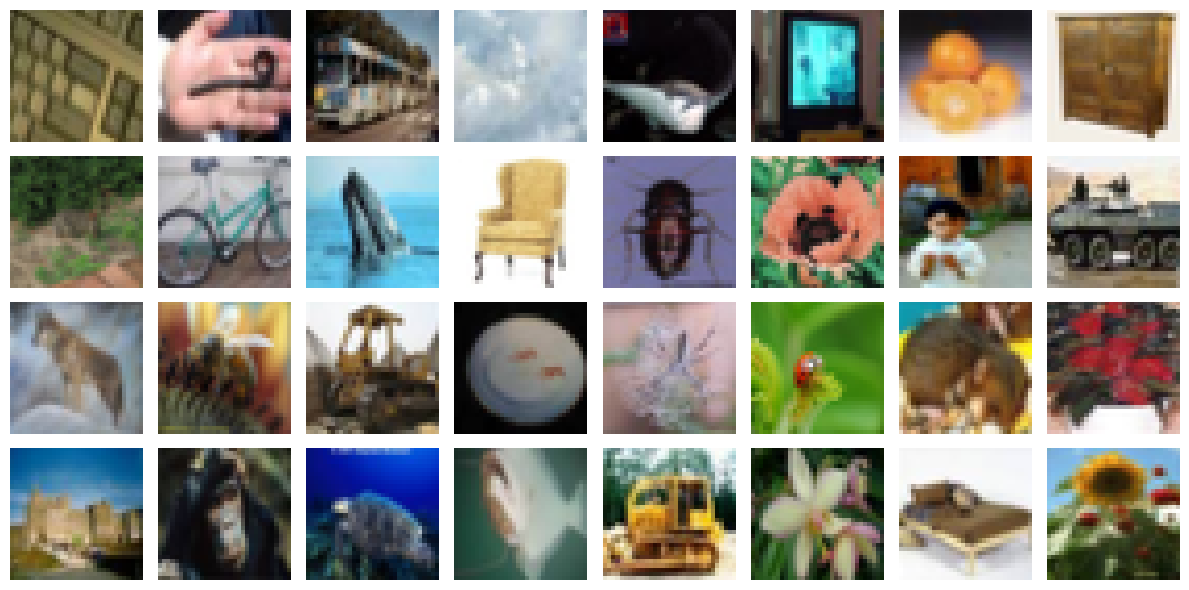

Epochs[13000/50000] Loss D: -2.3995, Loss G: 22.6685


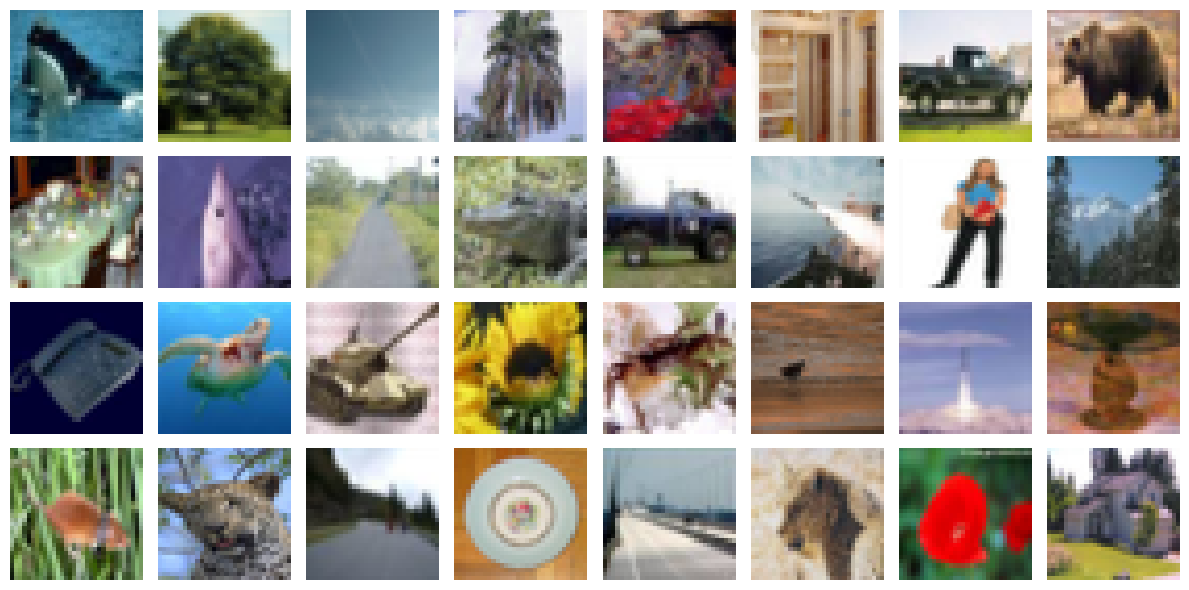

Epochs[14000/50000] Loss D: -2.1956, Loss G: 22.2972


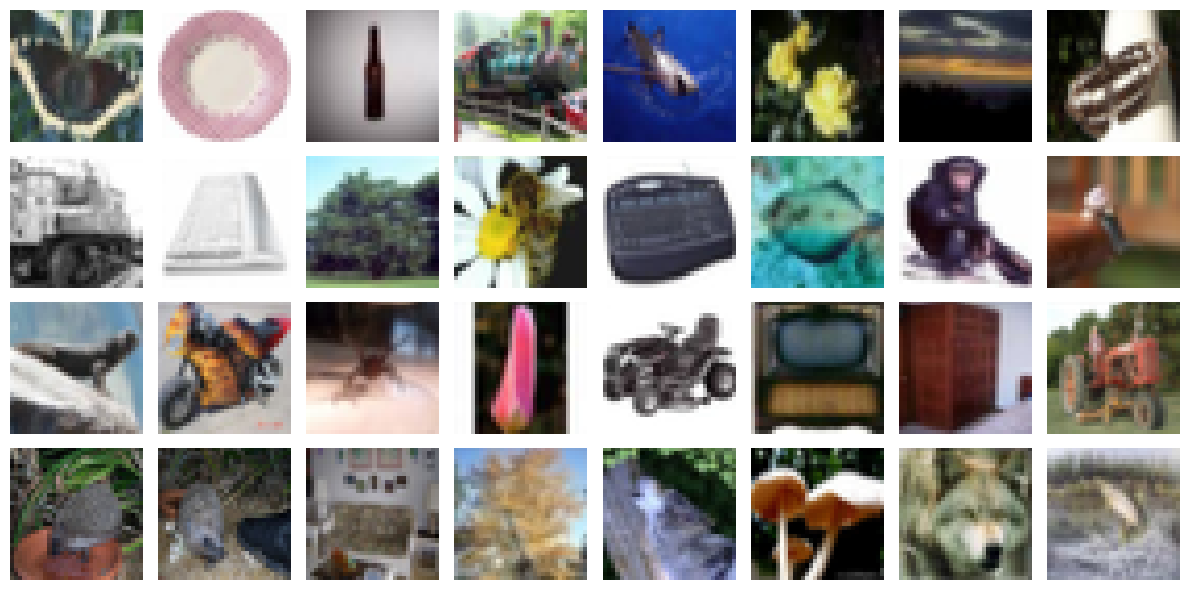

Epochs[15000/50000] Loss D: -1.8215, Loss G: 22.4306


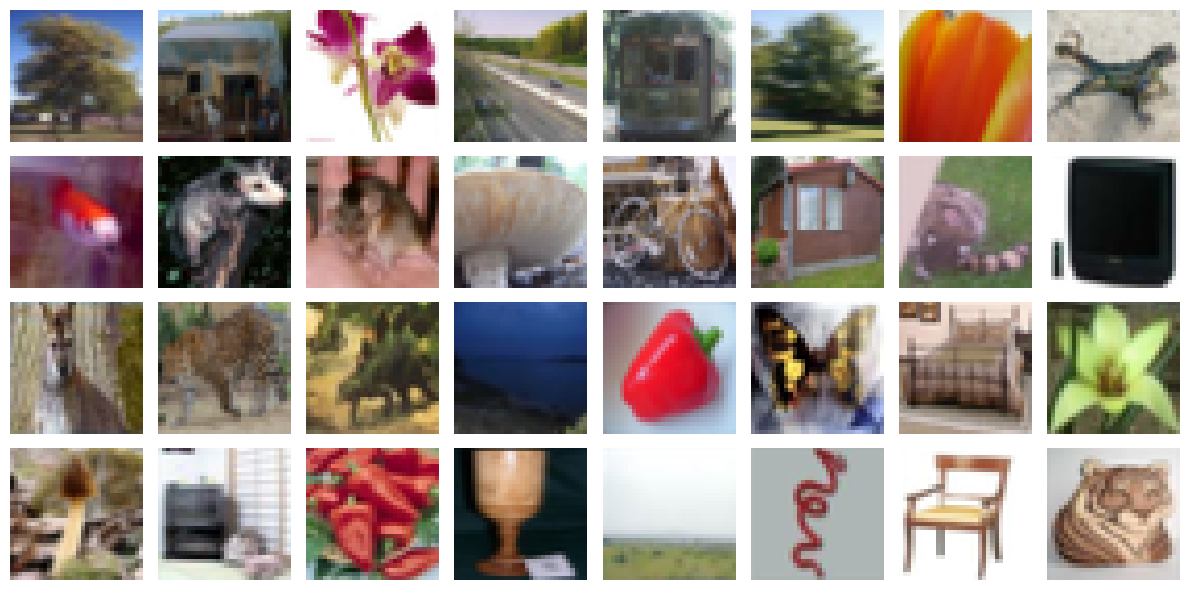

Epochs[16000/50000] Loss D: -1.5897, Loss G: 22.5612


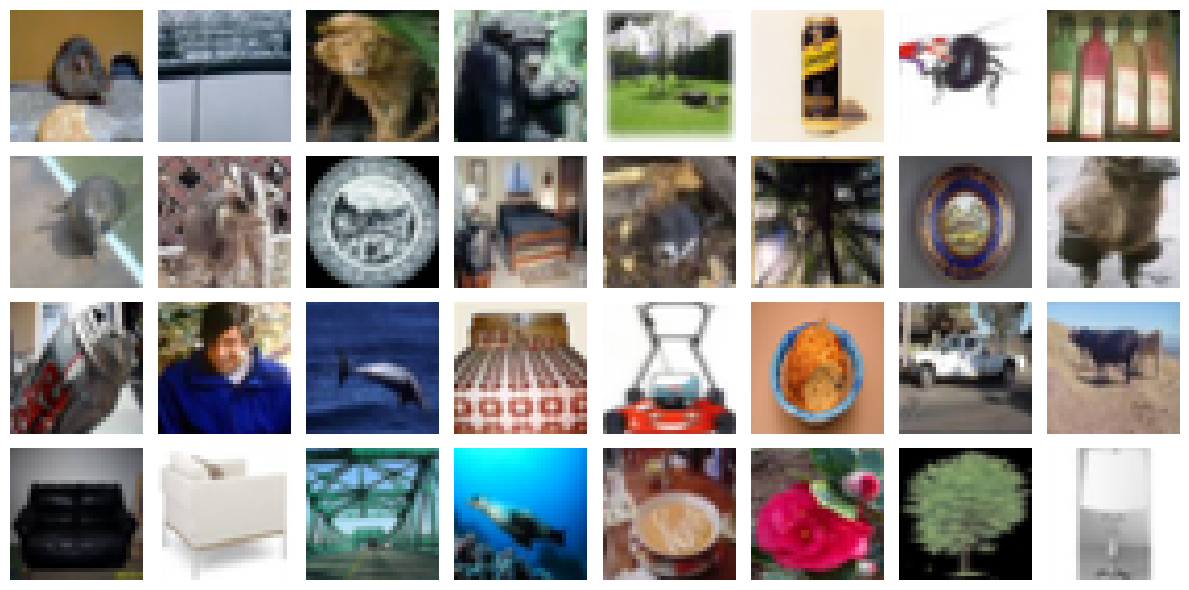

Epochs[17000/50000] Loss D: -1.8853, Loss G: 23.0484


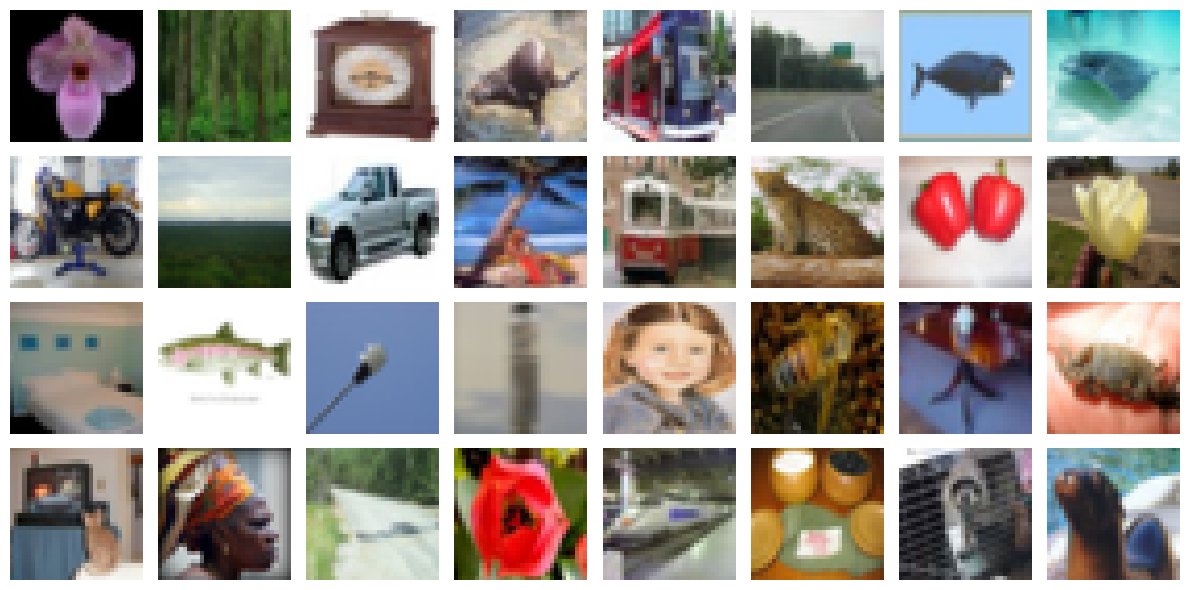

Epochs[18000/50000] Loss D: -1.5737, Loss G: 23.1773


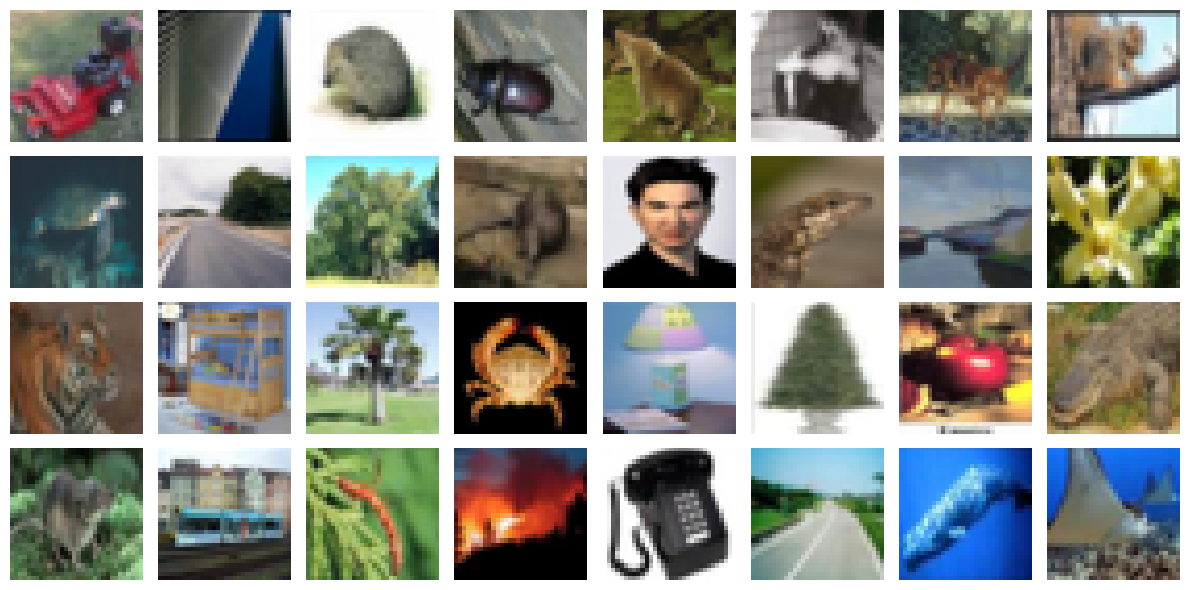

Epochs[19000/50000] Loss D: -1.9581, Loss G: 23.5866


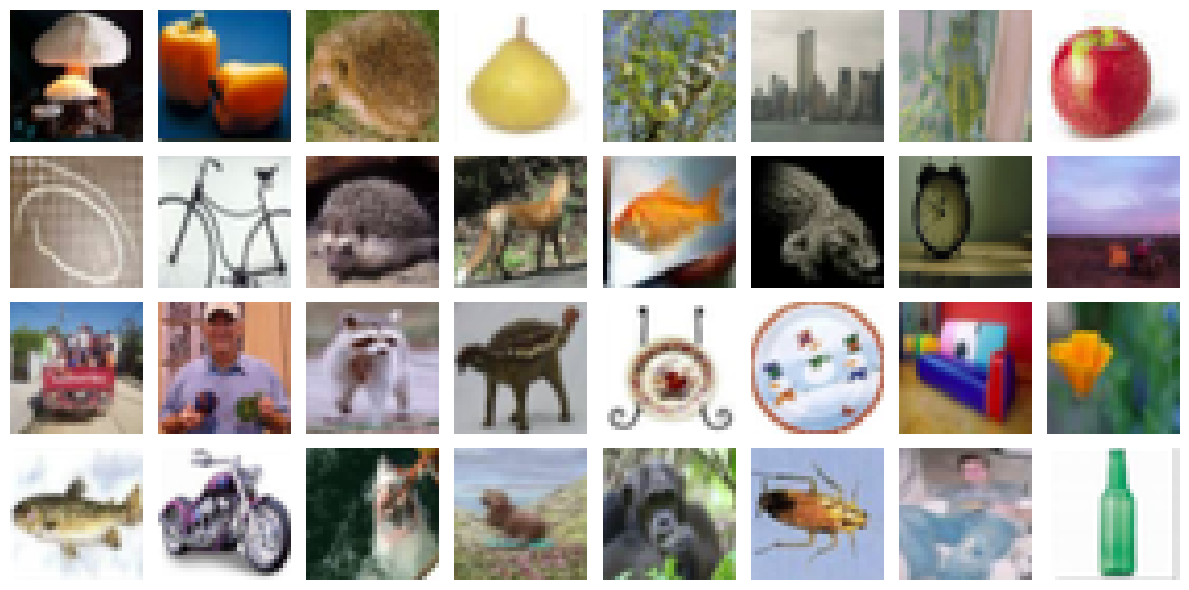

Epochs[20000/50000] Loss D: -1.9503, Loss G: 23.4081


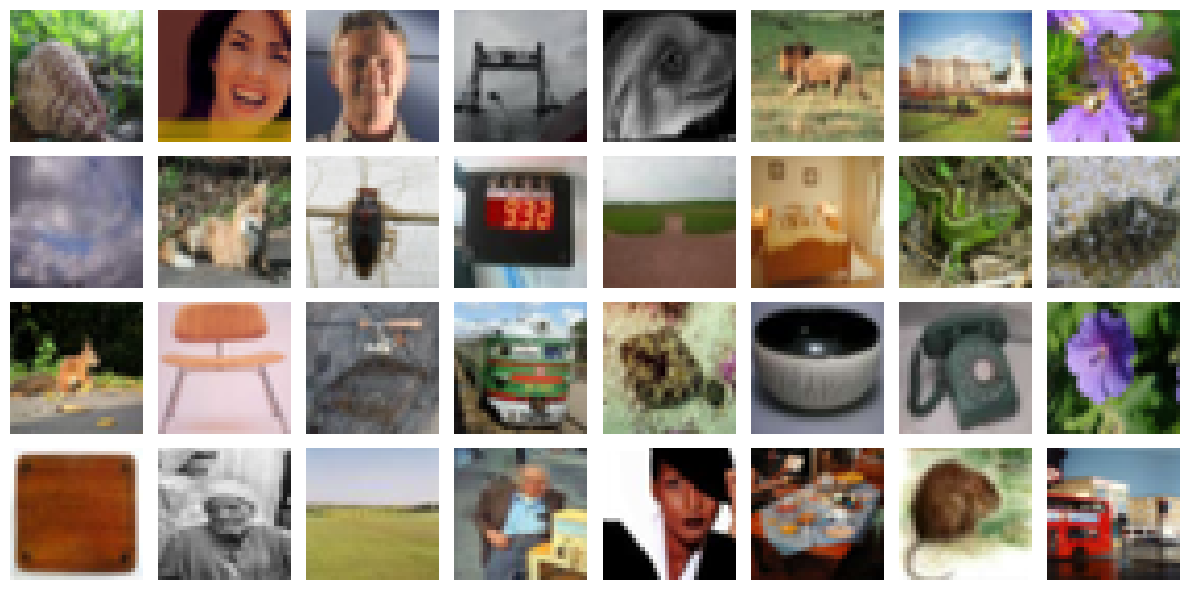

Epochs[21000/50000] Loss D: -2.0364, Loss G: 23.2204


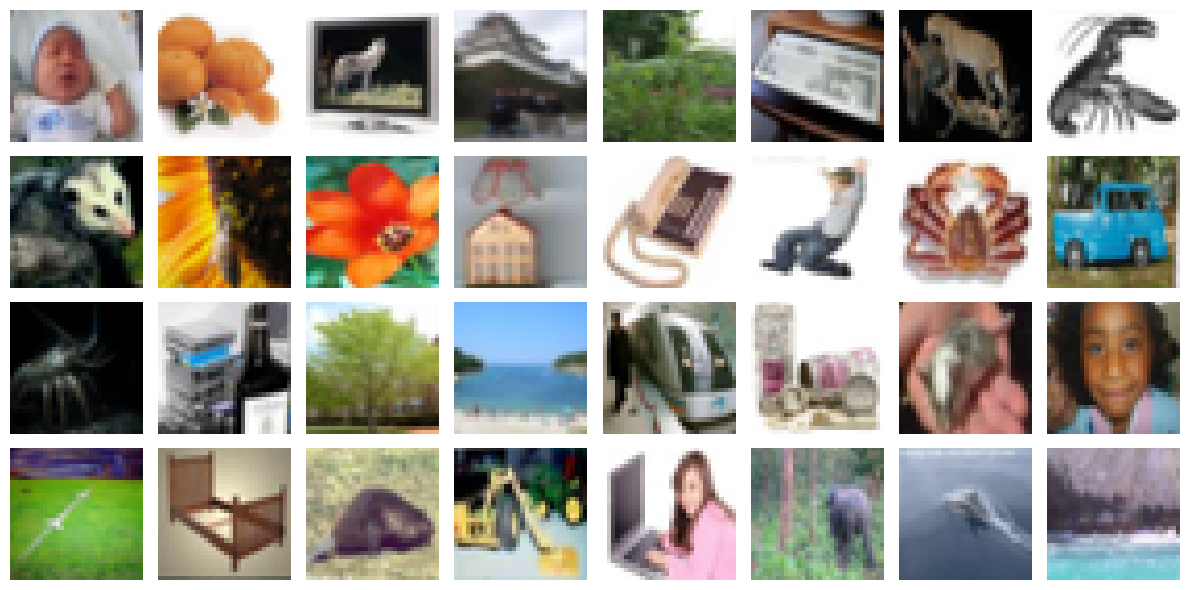

Epochs[22000/50000] Loss D: -2.1866, Loss G: 23.8278


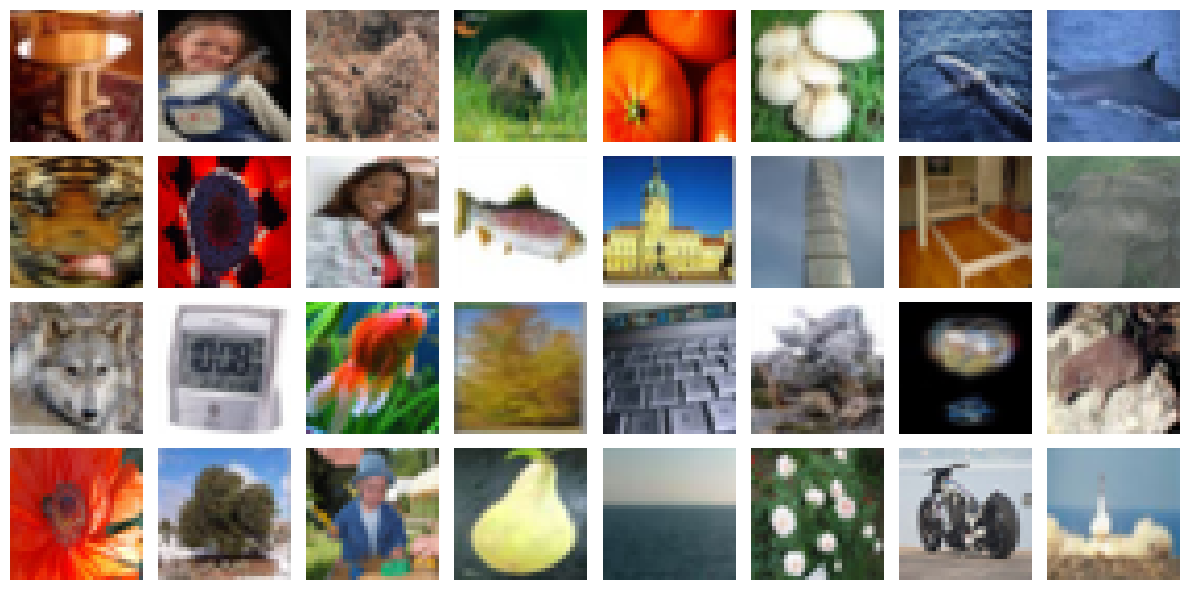

Epochs[23000/50000] Loss D: -2.3058, Loss G: 23.8160


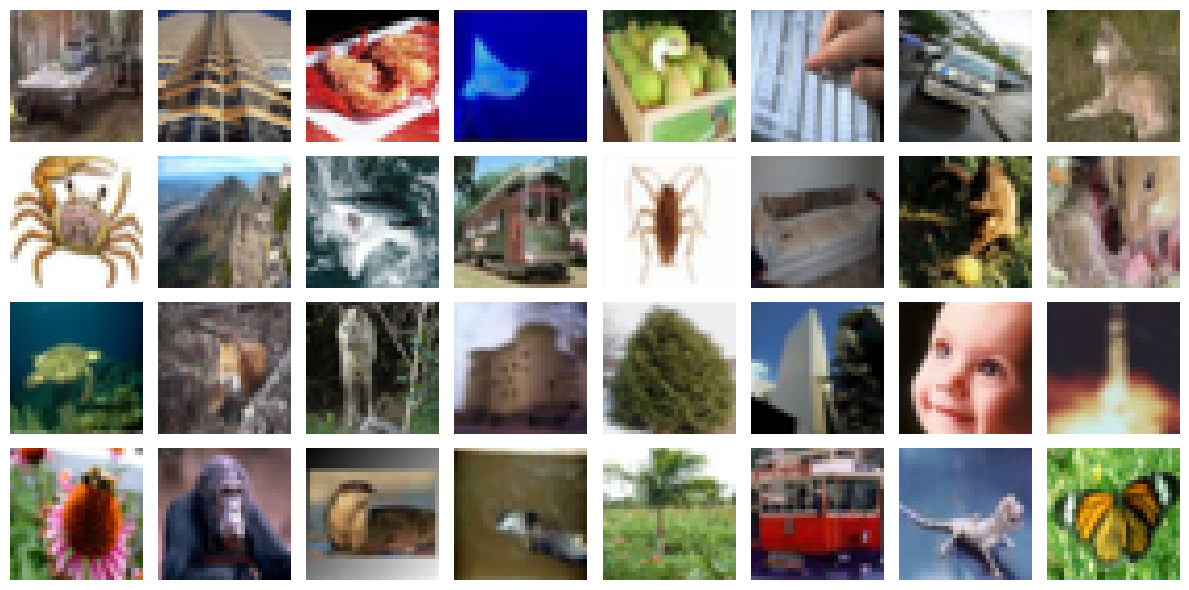

Epochs[24000/50000] Loss D: -1.9665, Loss G: 24.4058


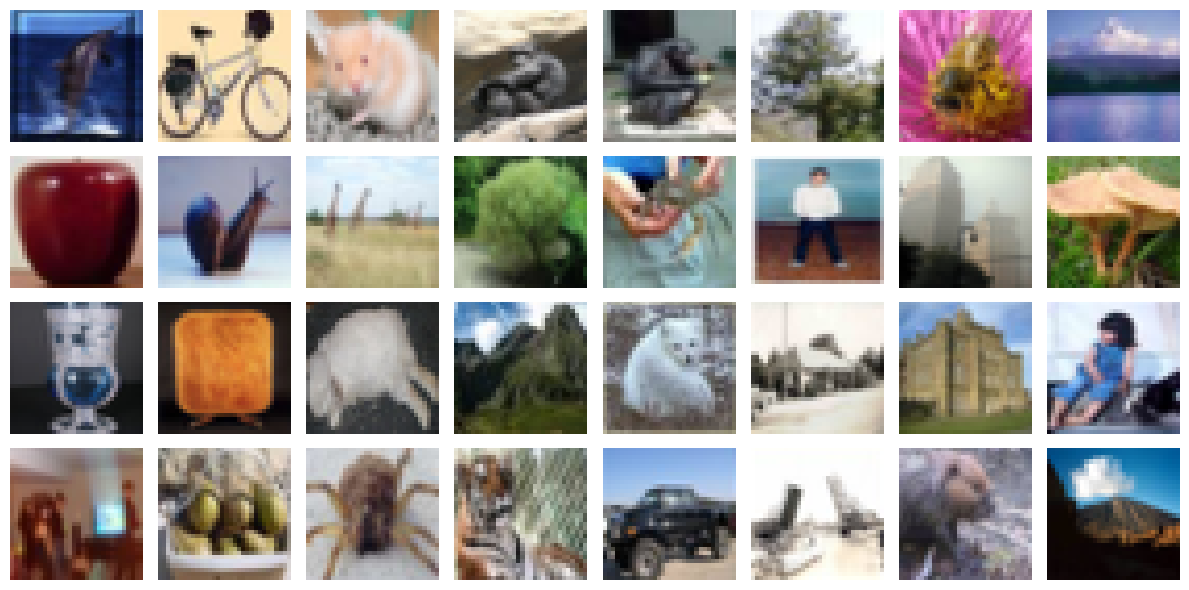

Epochs[25000/50000] Loss D: -2.5356, Loss G: 24.5710


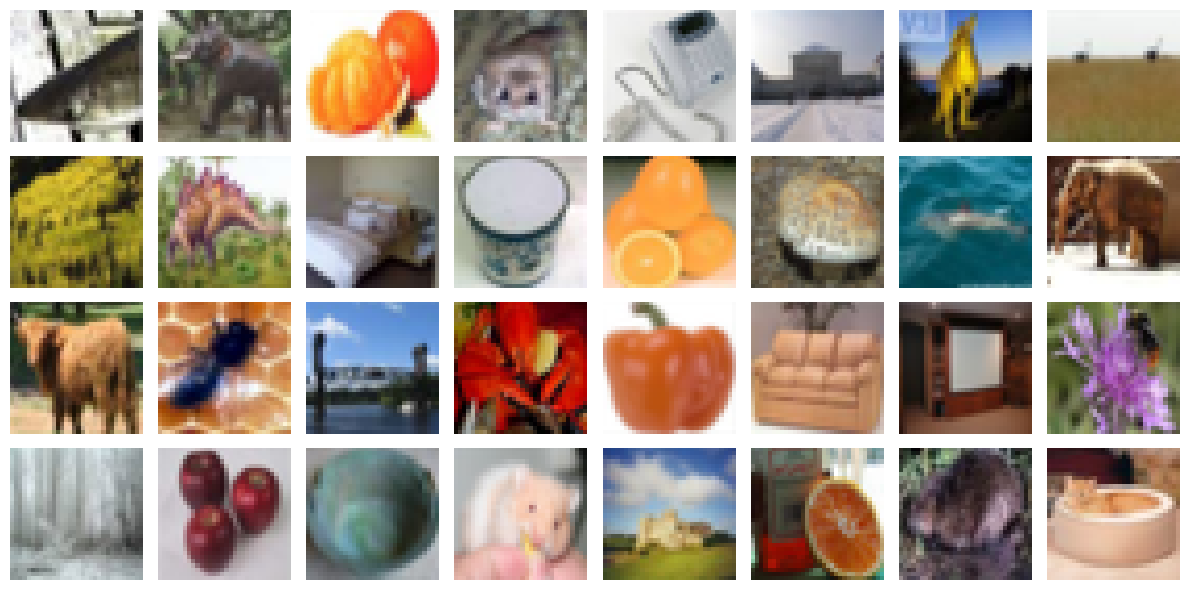

Epochs[26000/50000] Loss D: -1.9430, Loss G: 25.0094


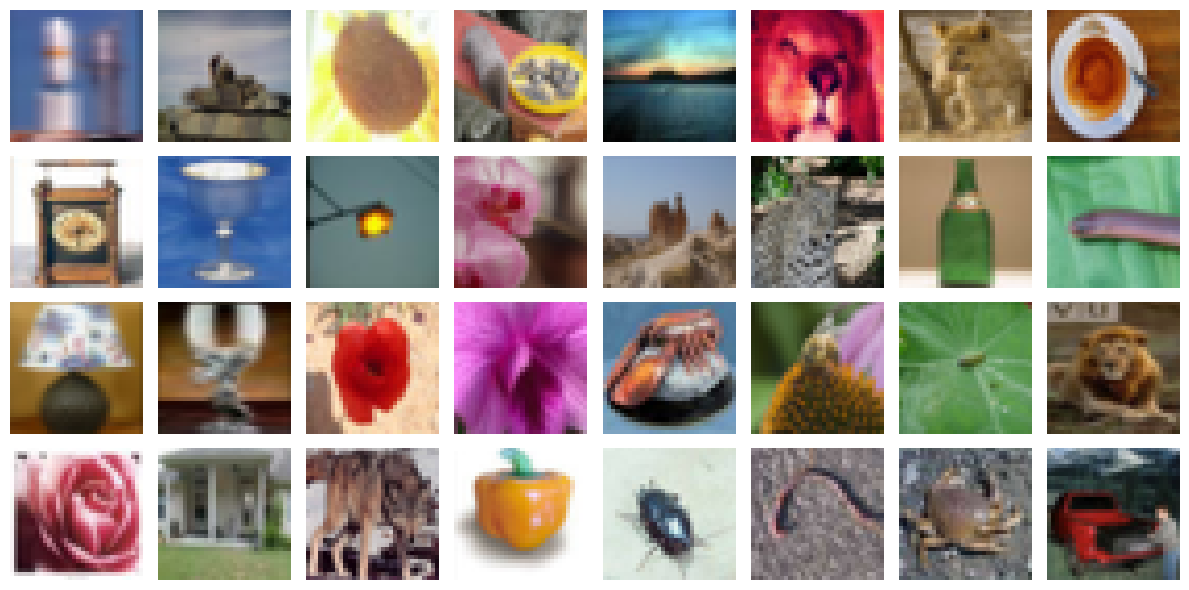

Epochs[27000/50000] Loss D: -2.3236, Loss G: 24.0063


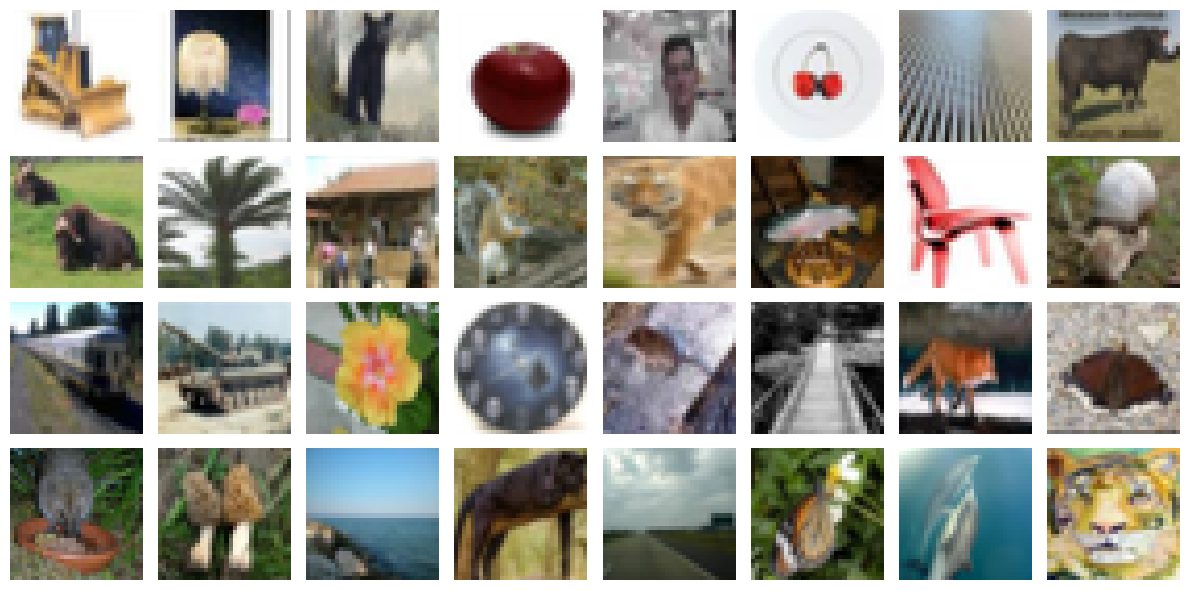

Epochs[28000/50000] Loss D: -1.7337, Loss G: 23.6326


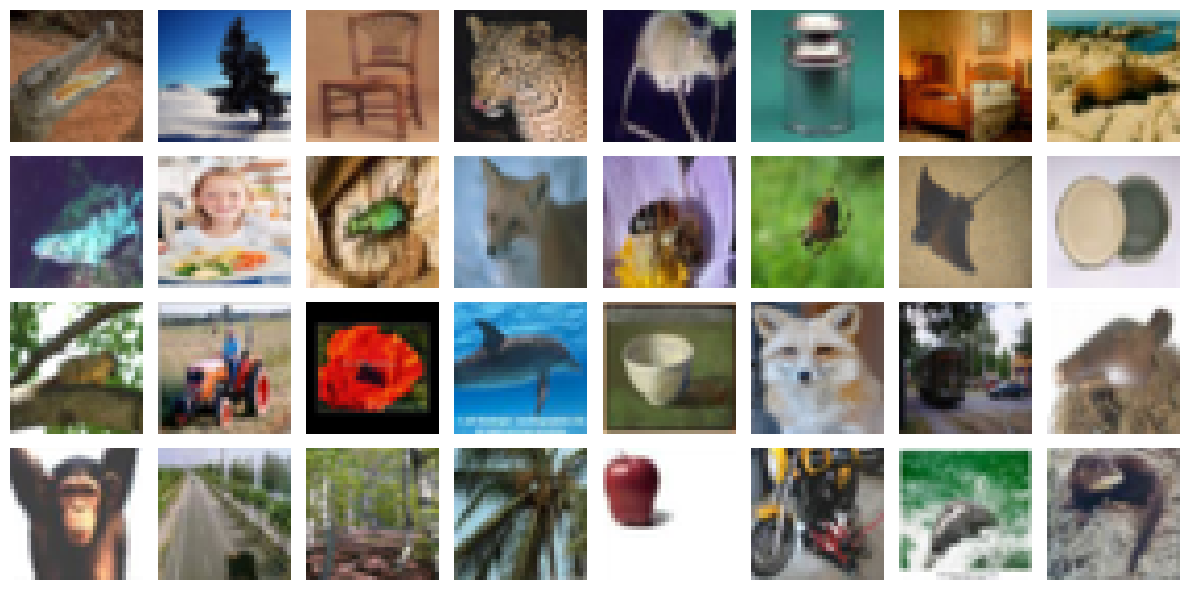

Epochs[29000/50000] Loss D: -1.9546, Loss G: 24.8685


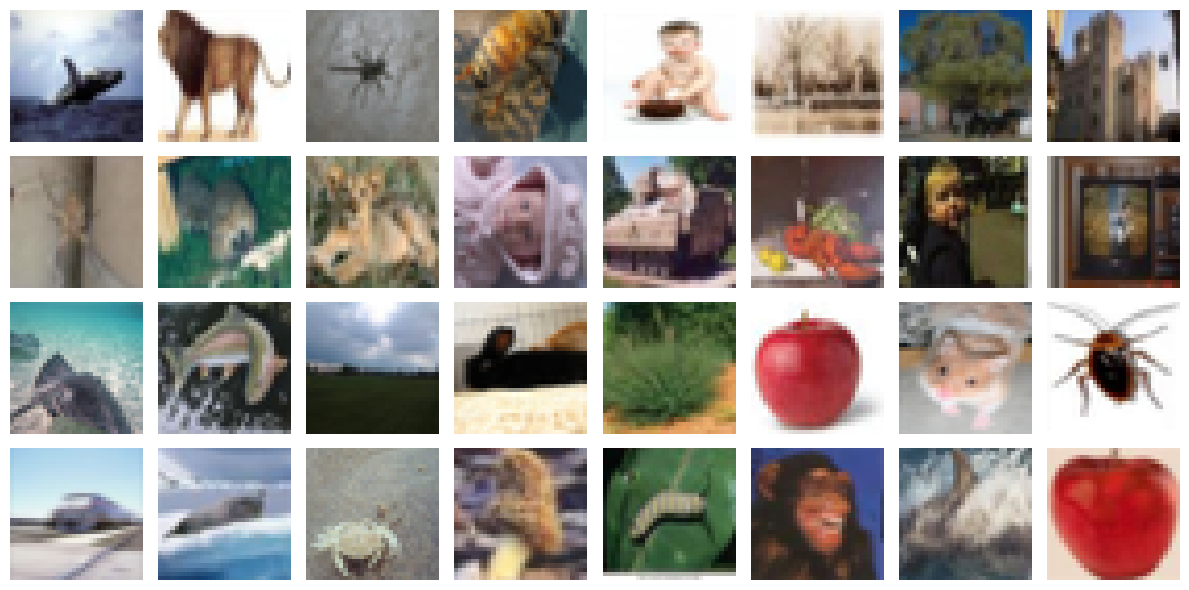

Epochs[30000/50000] Loss D: -1.9651, Loss G: 24.4895


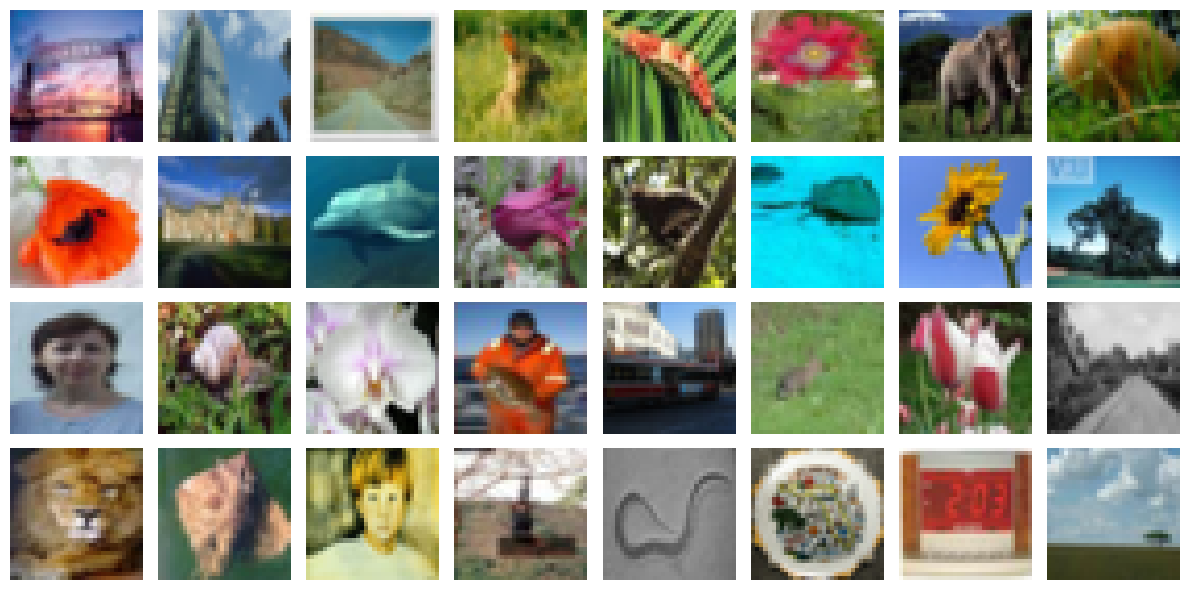

Epochs[31000/50000] Loss D: -1.6596, Loss G: 25.0024


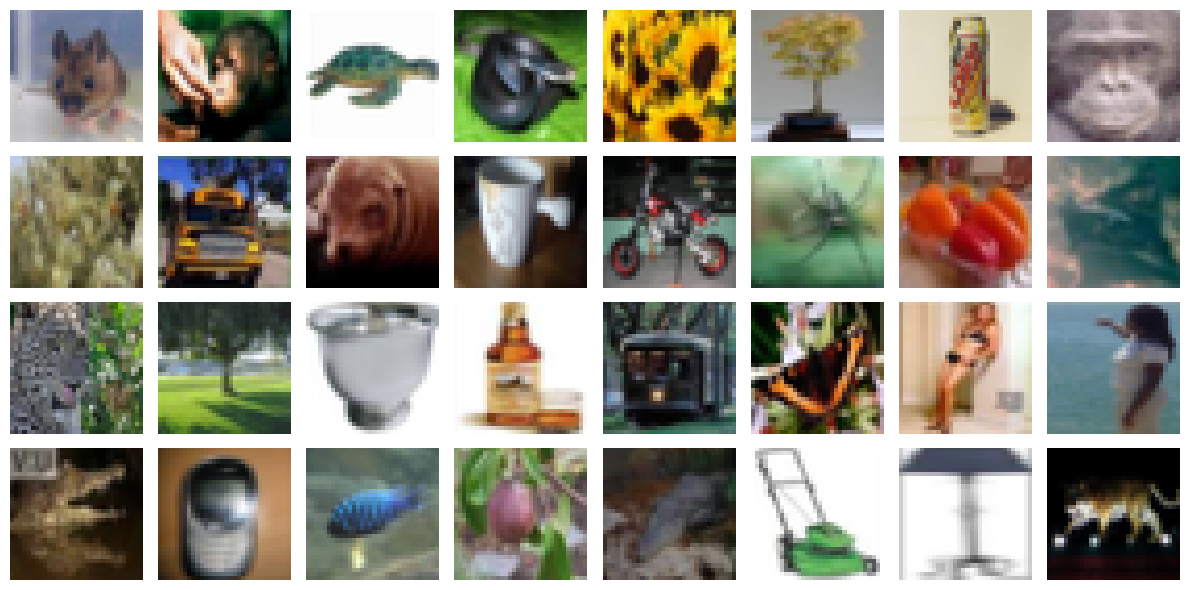

Epochs[32000/50000] Loss D: -1.3607, Loss G: 25.0063


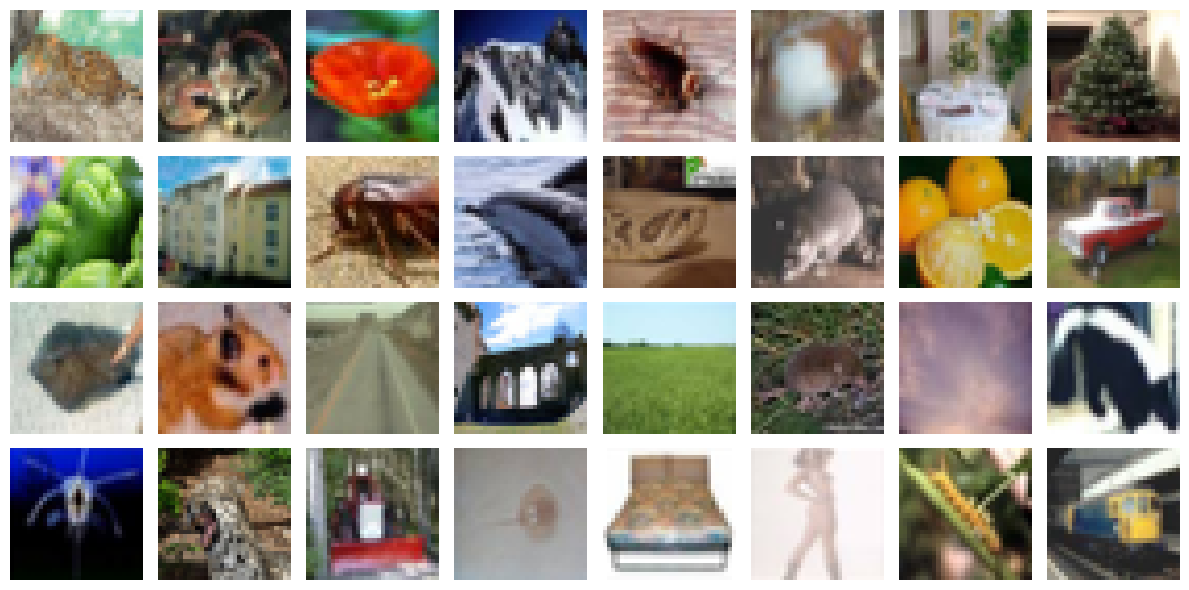

Epochs[33000/50000] Loss D: -1.7497, Loss G: 25.0012


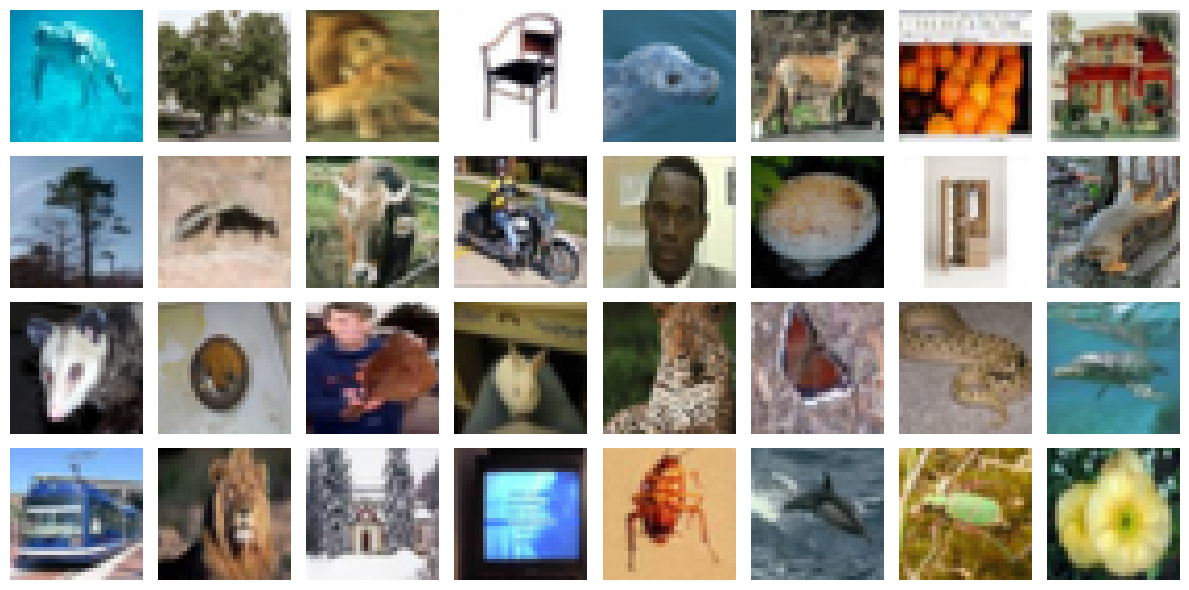

Epochs[34000/50000] Loss D: -1.7378, Loss G: 24.9514


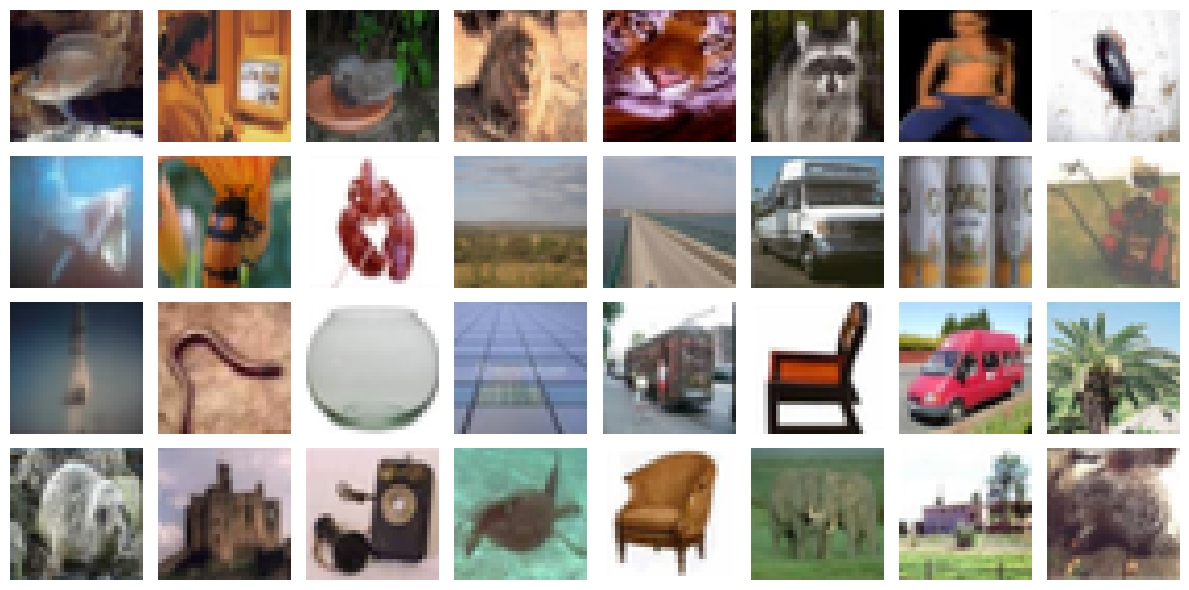

Epochs[35000/50000] Loss D: -1.9381, Loss G: 25.7925


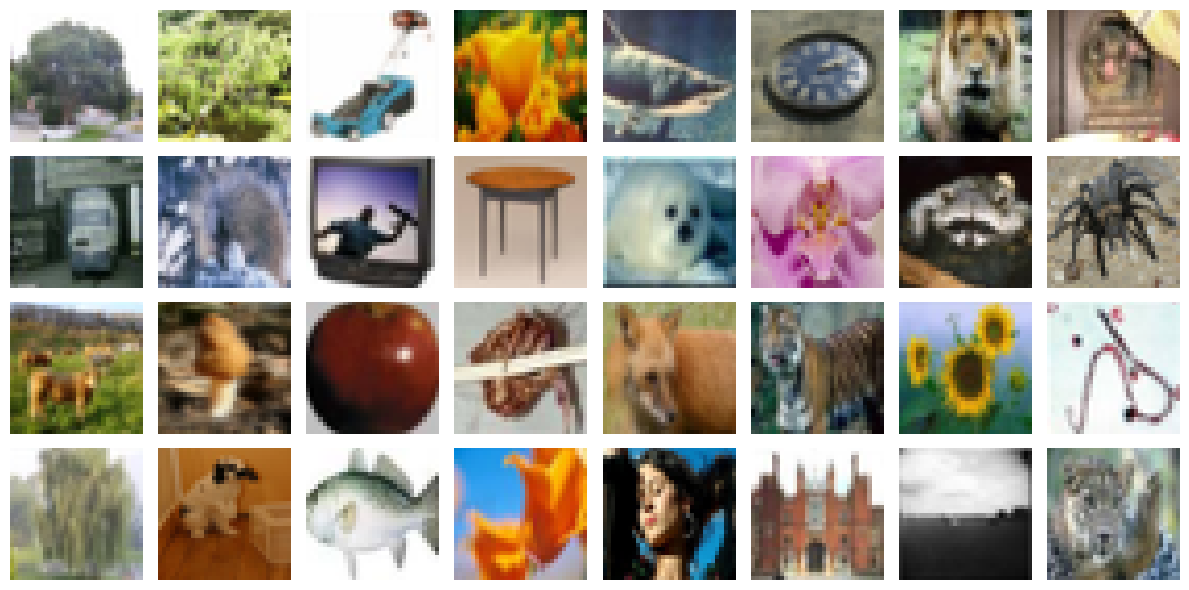

Epochs[36000/50000] Loss D: -1.2221, Loss G: 26.2003


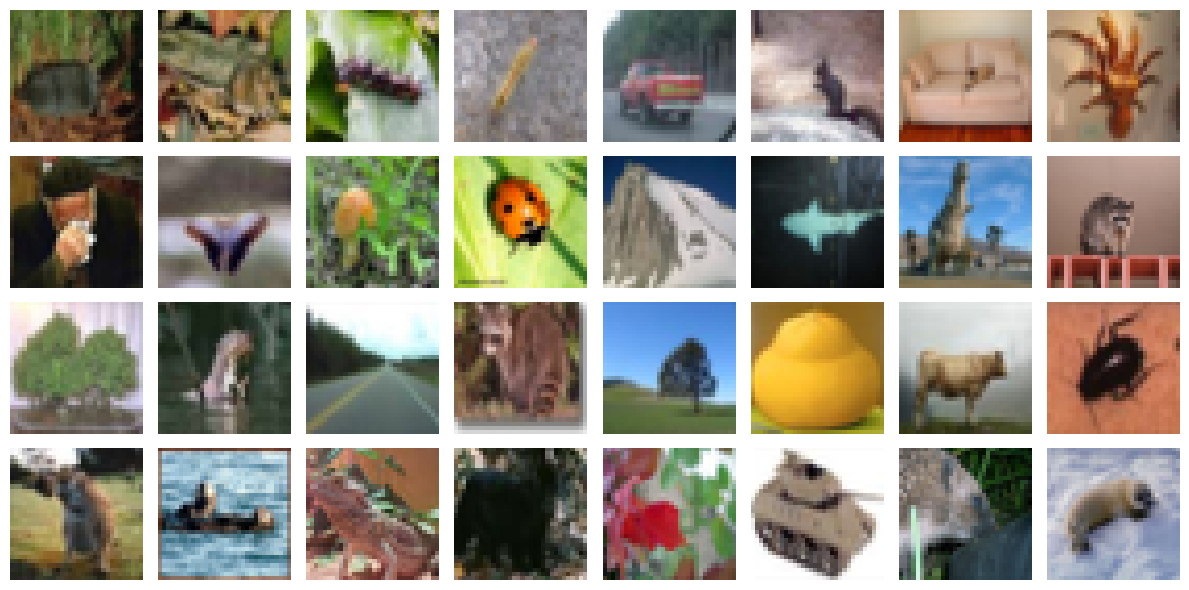

Epochs[37000/50000] Loss D: -2.0927, Loss G: 25.3102


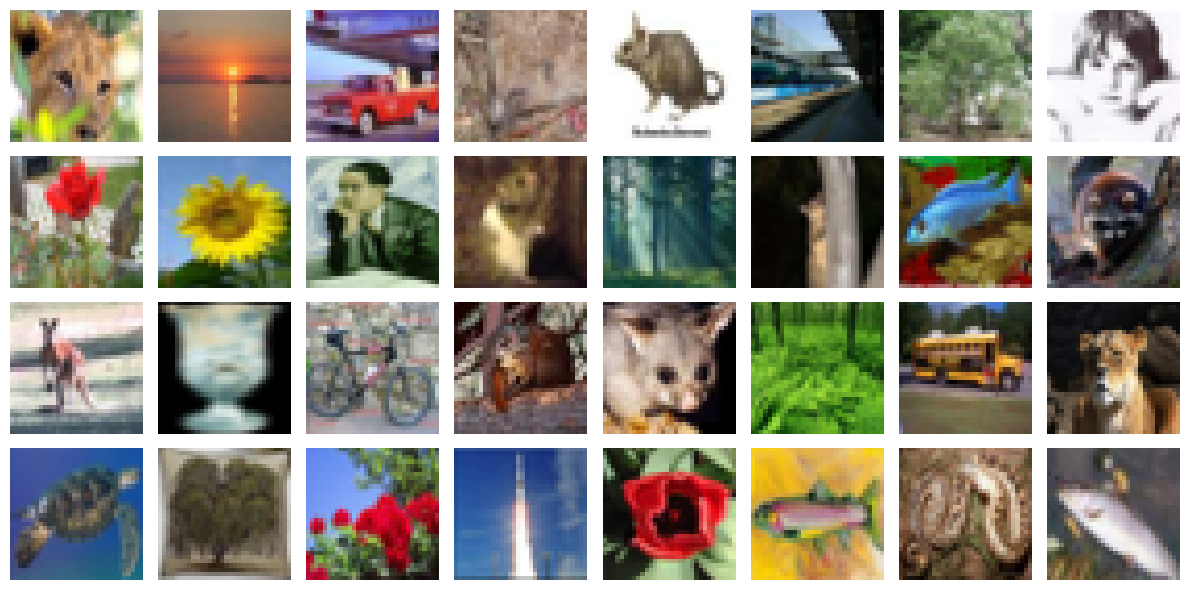

Epochs[38000/50000] Loss D: -1.7447, Loss G: 25.7951


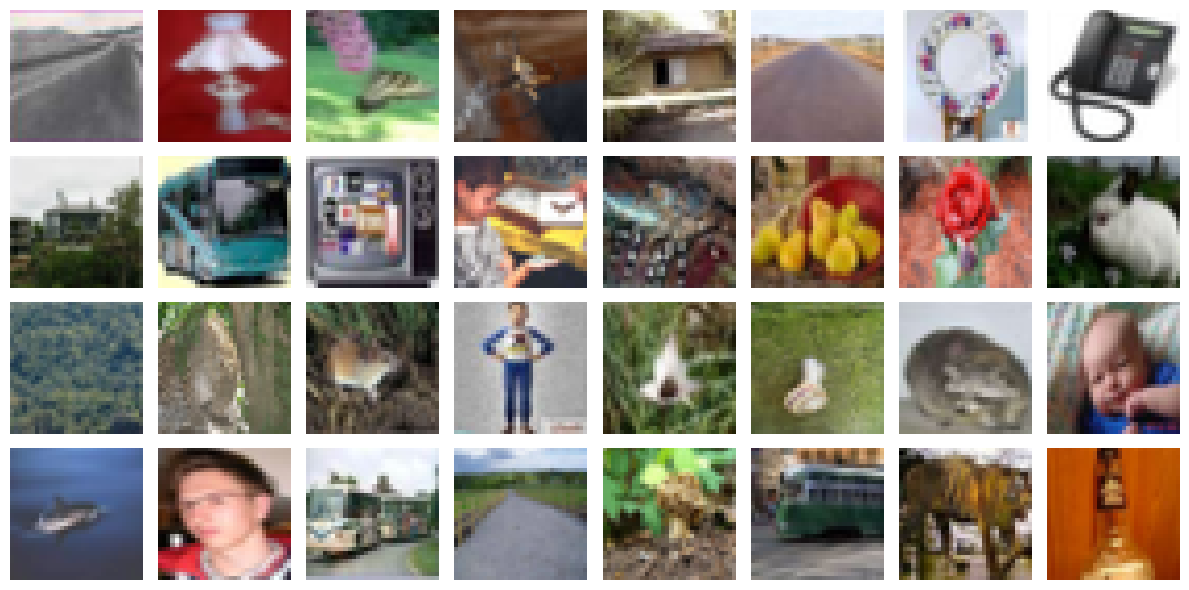

Epochs[39000/50000] Loss D: -1.8233, Loss G: 25.3735


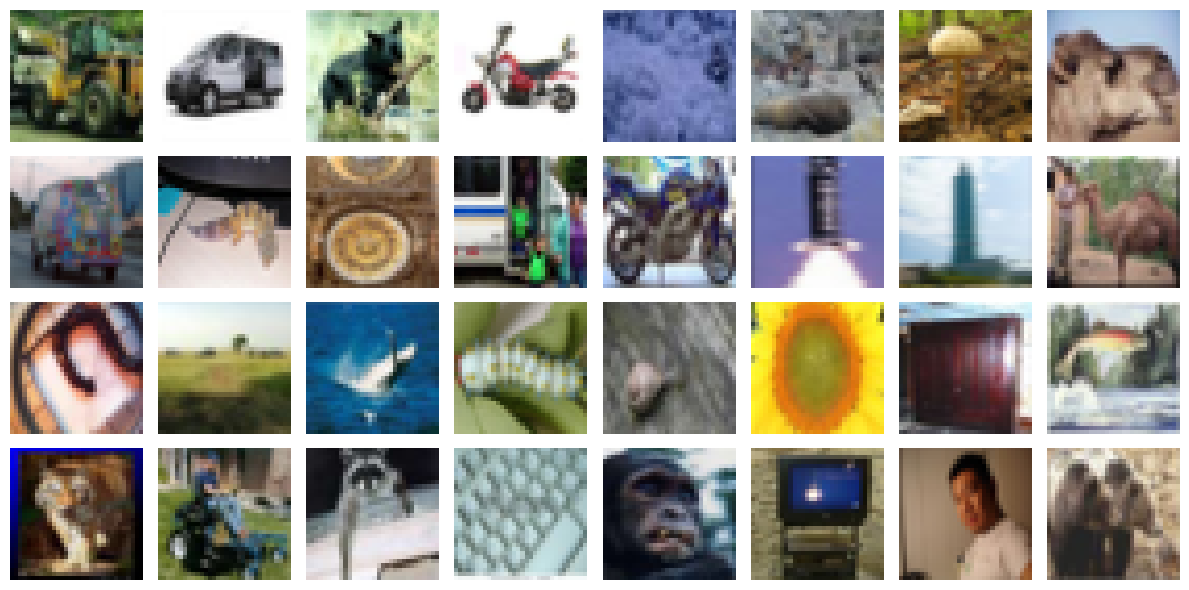

Epochs[40000/50000] Loss D: -1.9766, Loss G: 25.9924


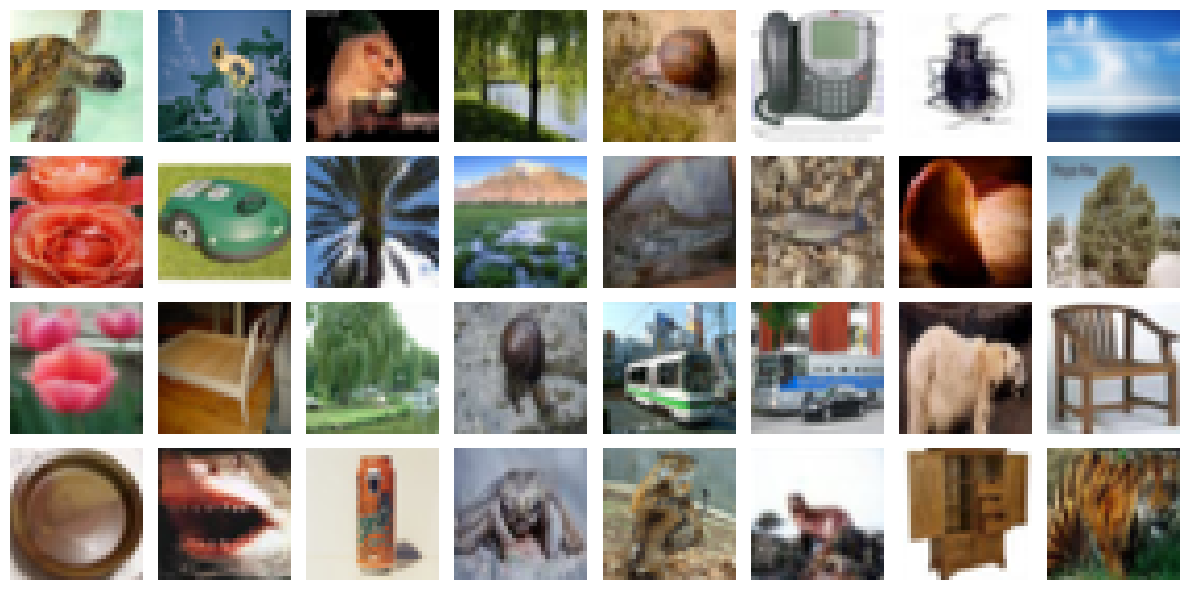

Epochs[41000/50000] Loss D: -2.1348, Loss G: 26.9216


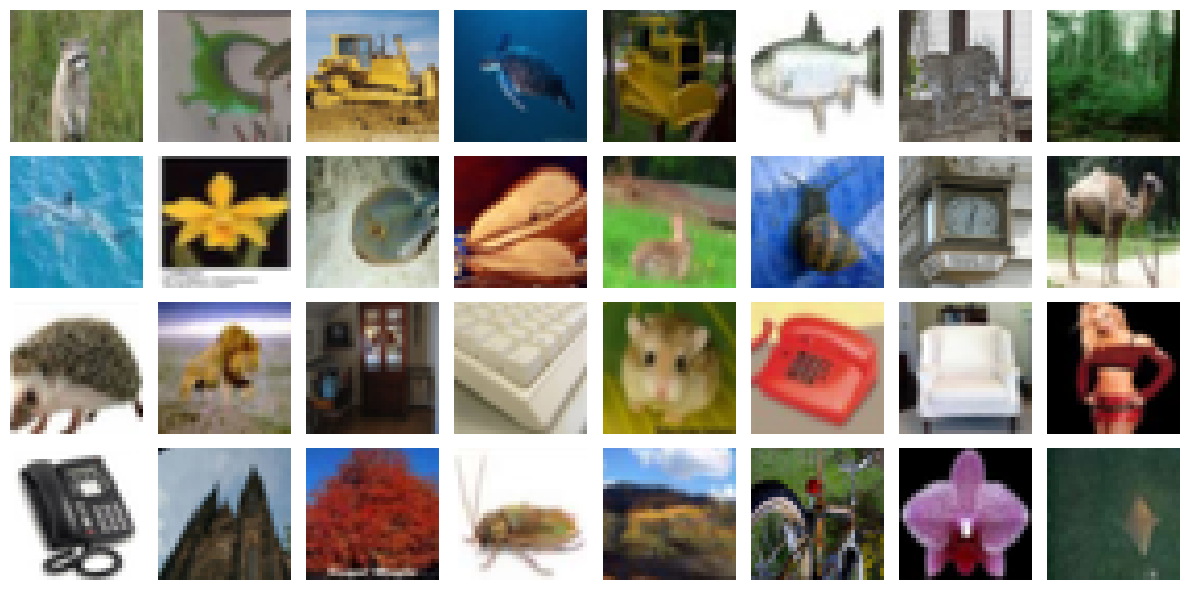

Epochs[42000/50000] Loss D: -1.4157, Loss G: 25.7873


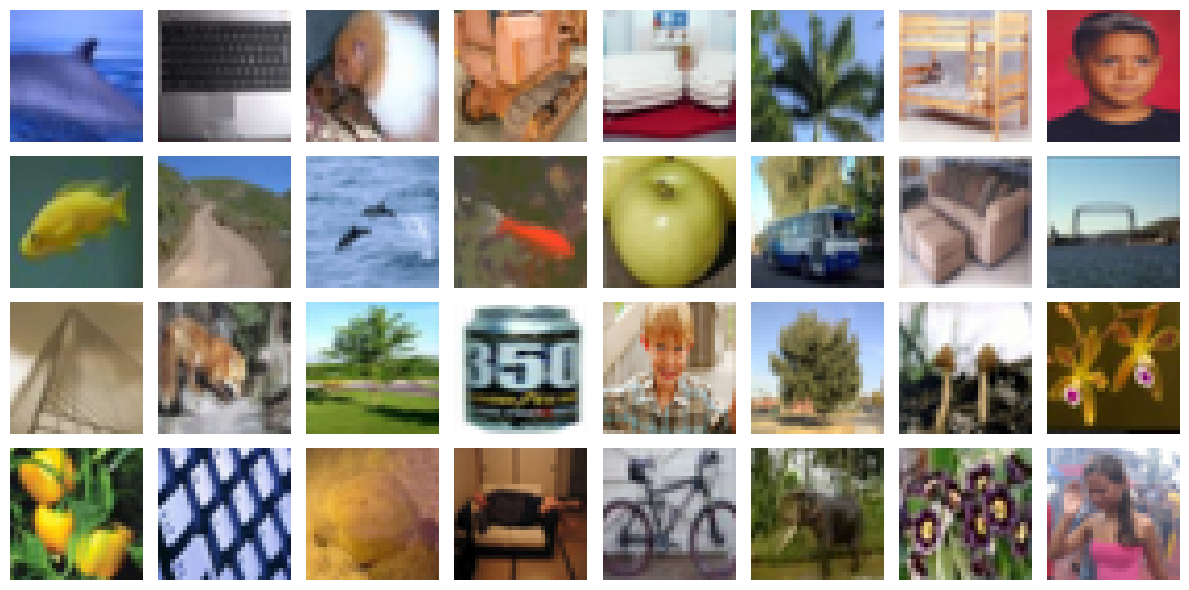

Epochs[43000/50000] Loss D: -1.2231, Loss G: 27.5665


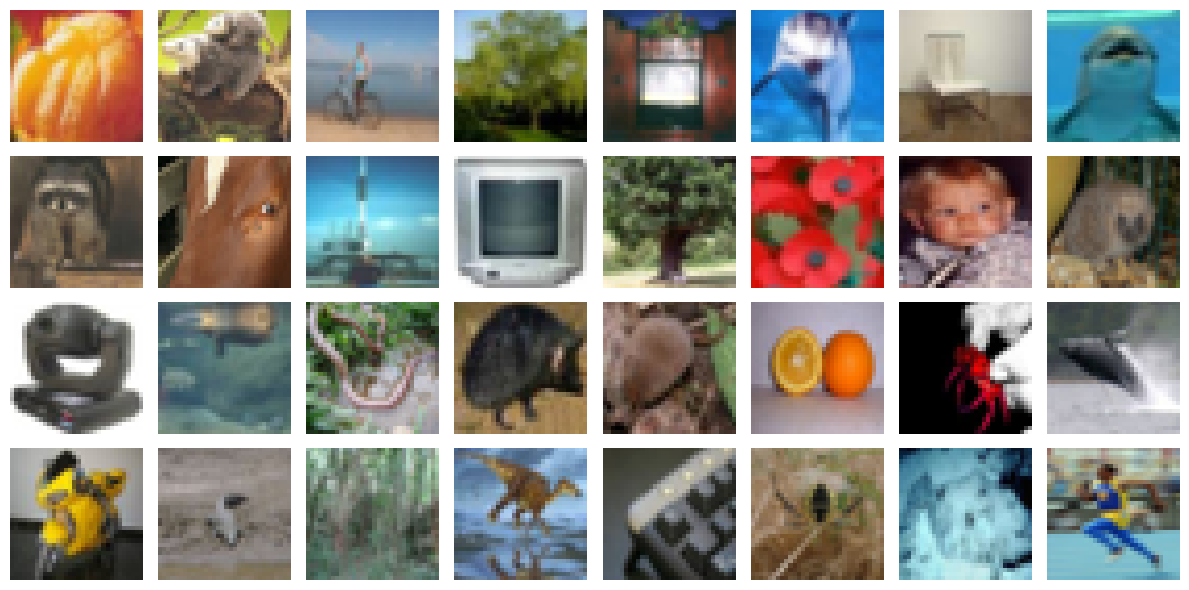

Epochs[44000/50000] Loss D: -1.4495, Loss G: 27.9413


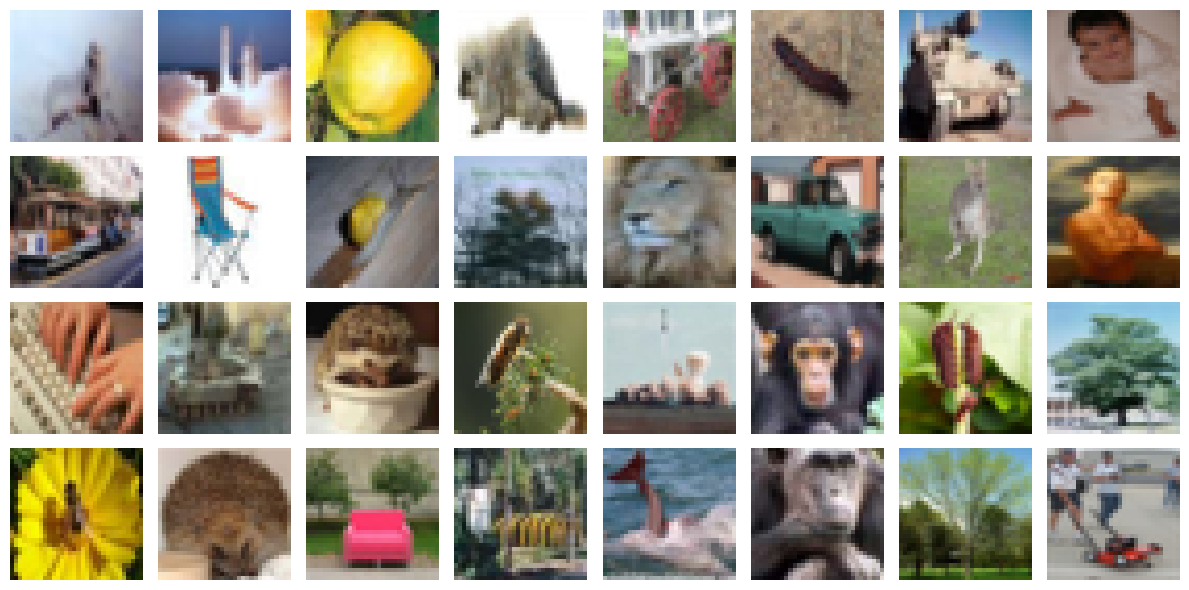

Epochs[45000/50000] Loss D: -1.7367, Loss G: 27.4573


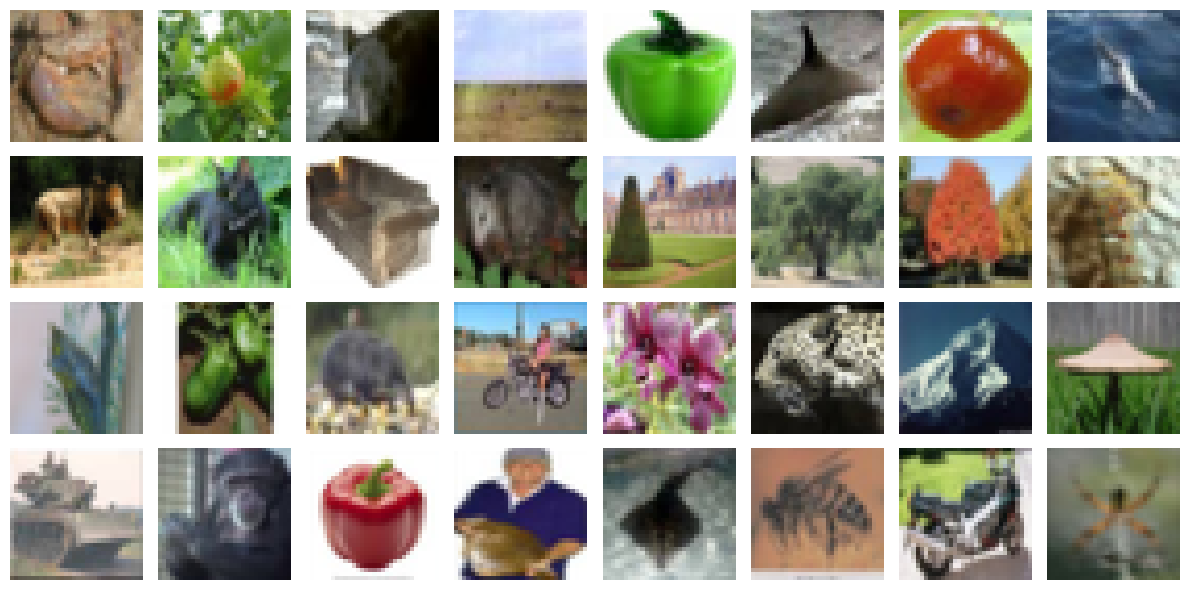

Epochs[46000/50000] Loss D: -1.7152, Loss G: 27.6483


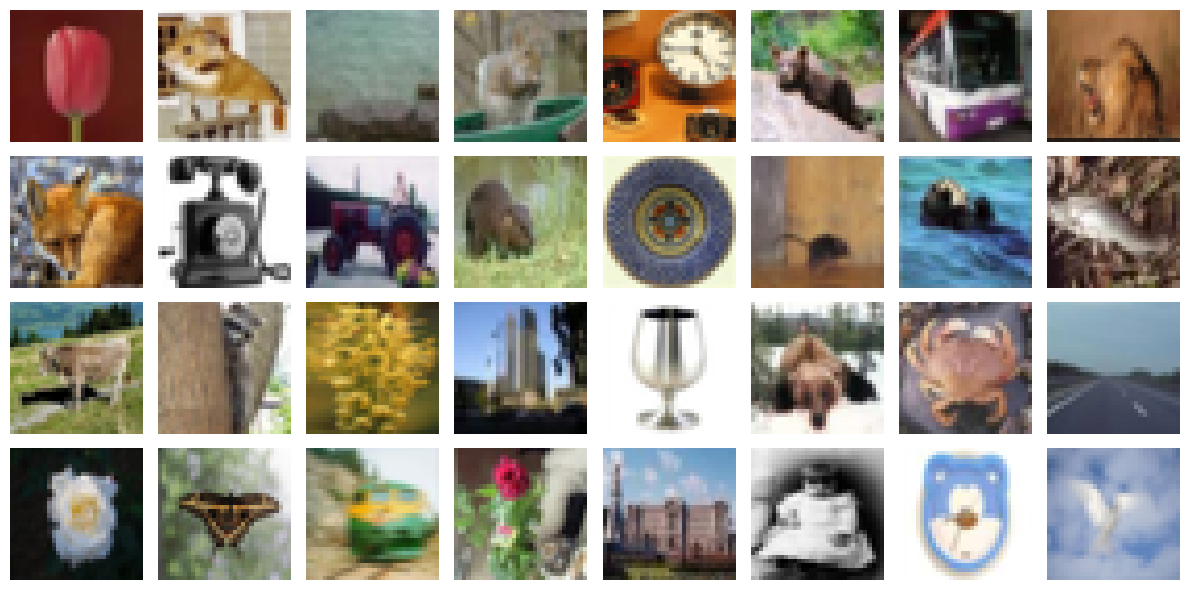

Epochs[47000/50000] Loss D: -2.1944, Loss G: 28.8535


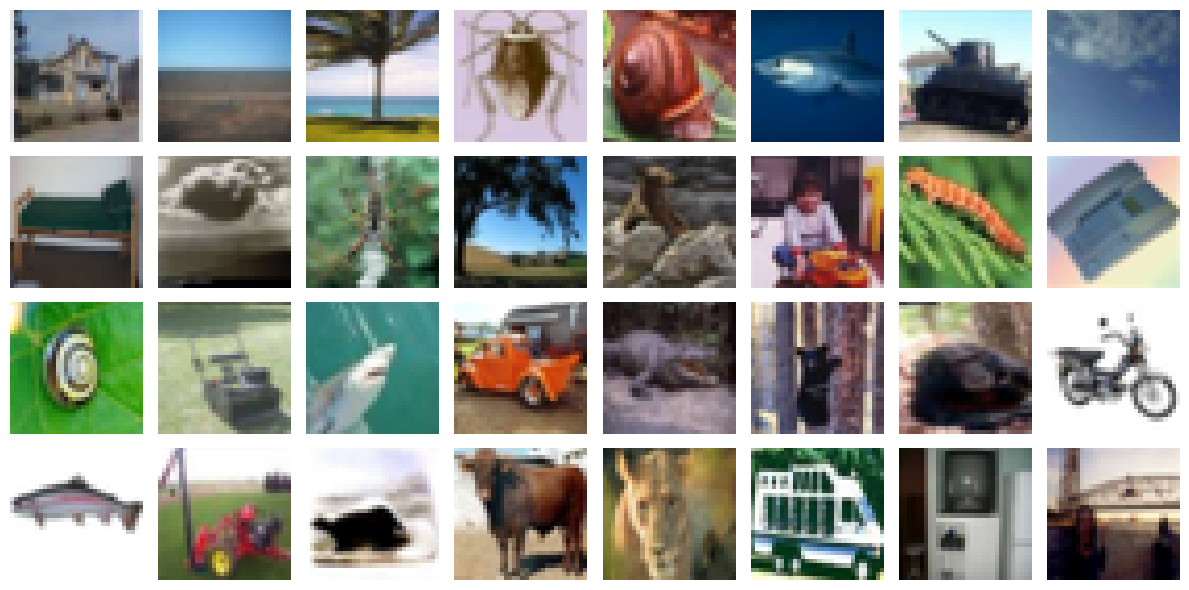

Epochs[48000/50000] Loss D: -1.7185, Loss G: 28.7485


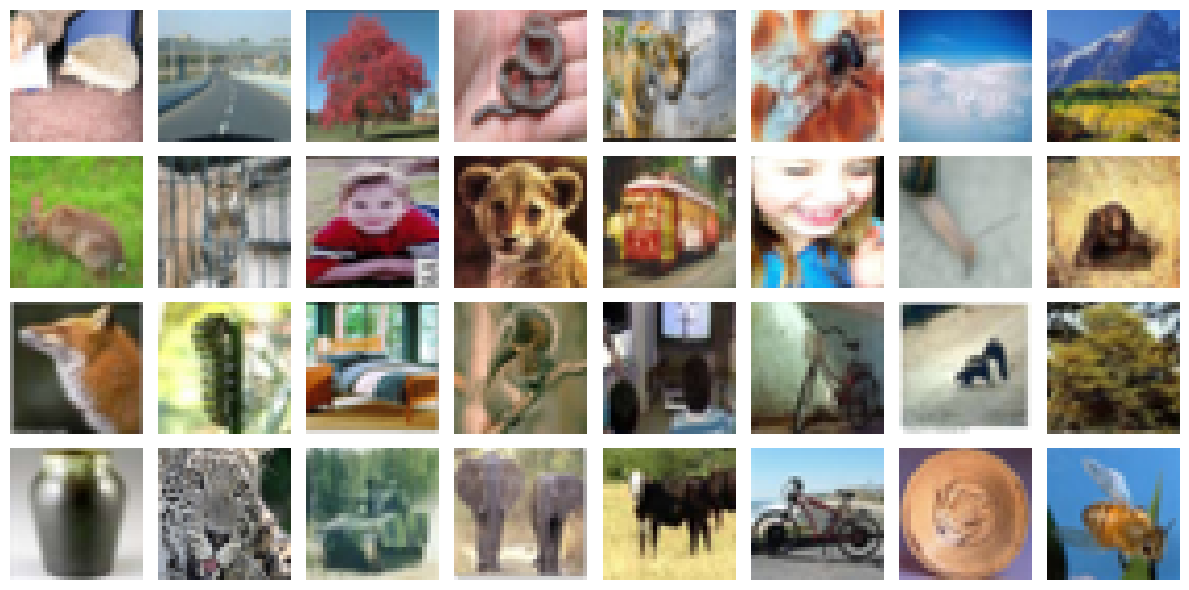

Epochs[49000/50000] Loss D: -1.5008, Loss G: 29.1085


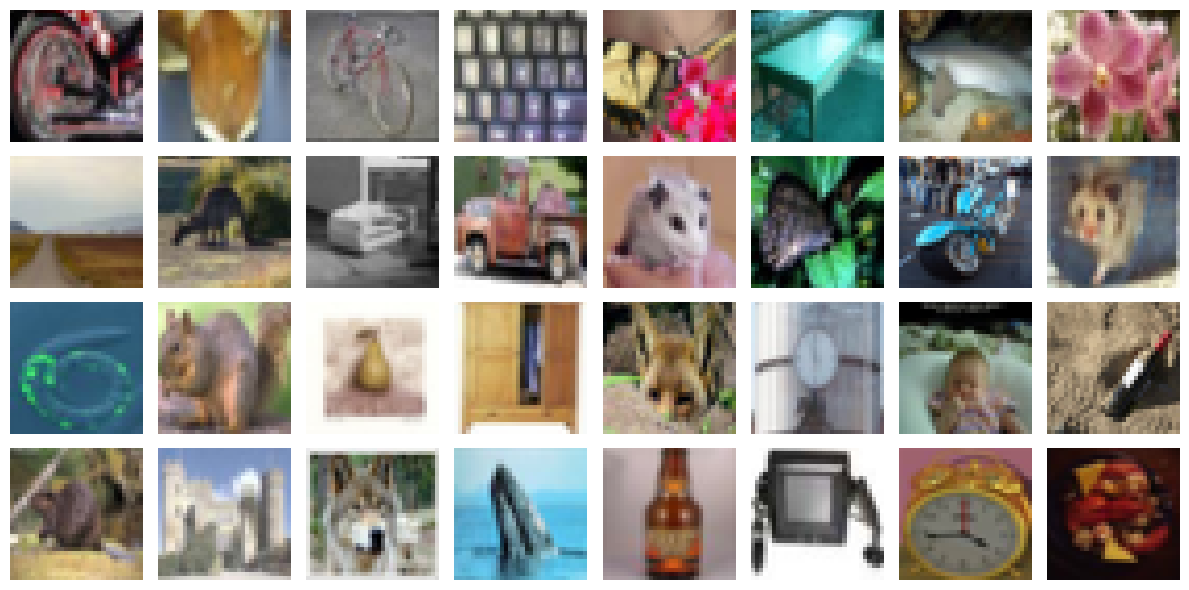

Epochs[50000/50000] Loss D: -1.5036, Loss G: 29.6759


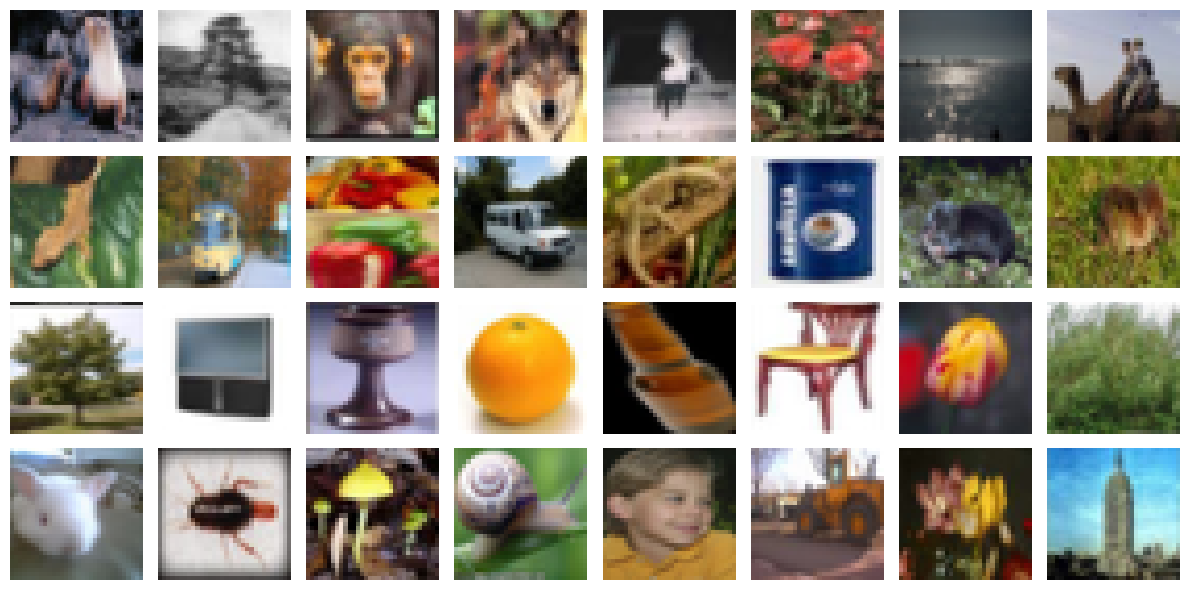

Steps:  50001


In [116]:
def denormalize(img):
    img = img * 0.5 + 0.5 
    return img

step = 0
total_steps = 50000

while step < total_steps:
    for batch_idx, (real, _) in enumerate(train_loader):
        if step >= total_steps:
            break

        real = real.to(device)

        for i in range(5):
            noise = torch.randn(Batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        noise = torch.randn(Batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        step += 1

        if step % 1000 == 0:
            print(f"Epochs[{step}/{total_steps}] "
                  f"Loss D: {loss_critic:.4f}, Loss G: {loss_gen:.4f}")
            with torch.no_grad():
                fake = gen(fixed_noise)

                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                
                step += 1

            # Display a grid of images without class labels
            fig, axes = plt.subplots(4, 8, figsize=(12, 6))
            for i, ax in enumerate(axes.flatten()):
                if i < len(real):
                    img = real[i].cpu().permute(1, 2, 0).numpy()
                    img = denormalize(img)  # Denormalize the image
                    ax.imshow(img)
                    ax.axis('off')
            plt.tight_layout()
            plt.show()

print("Steps: ", step)


In [117]:
%%capture
!pip install clean-fid
import os
from cleanfid import fid
from torchvision.utils import save_image

In [120]:
# define directories
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # do not change

# create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        !rm -r {directory}
    os.makedirs(directory)

# setup_directory(real_images_dir)
# setup_directory(generated_images_dir)

# generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:
    # sample from your model, you can modify this
    z = torch.randn(64, 28).to(device)
    samples_batch = gen.sample(z).cpu().detach()
    for image in samples_batch:
        if num_generated >= num_samples:
            break
        torchvision.utils.save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1

# save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break
        torchvision.utils.save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [64, 28]

In [ ]:
# compute FID
import cleanfid

score = cleanfid.fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")